# Evaluation on Kang Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_fscore_support
import benchmark as bm
from prismo import feature_sets as fs
import matplotlib.pyplot as plt
# import seaborn as sns
import pathlib
import os
from plotnine import *
import pandas as pd
from sklearn.metrics import roc_auc_score
import scanpy as sc


%matplotlib
%matplotlib inline

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/anndata/utils.py:429: Futu

Spectra GPU support is still under development. Raise any issues on github 
 
 Changes from v1: 
 (1) GPU support [see tutorial] 
 (2) minibatching for local parameters and data 
 Note that minibatching may affect optimization results 
 Code will eventually be merged into spectra.py
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
device = "cuda:1"
seed = 2411111440
rng = np.random.default_rng(seed)

# Discrete colors
colors_disc = [
    "#FF9999",
    "#66B2FF",
    "#99FF99",
    "#FFCC99",
    "#FF99CC",
    "#99CCFF",
    "#FF6666",
    "#66CC00",
]
# Continuous colors
colors_div = ["#214D83", "#7D1B26"]  # blue, red

VS_CODE_REMOTE = True
if VS_CODE_REMOTE:
    os.chdir(pathlib.Path().absolute() / "benchmark")
    import benchmark as bm
    import plotting

In [4]:
adata = ad.read_h5ad("data/kang_tutorial.h5ad").copy()
adata.var_names = adata.var_names.str.upper()
adata._inplace_subset_var(adata.to_df().std() > 0.2)

gene_set_collection = fs.from_gmt("../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt")
# gene_set_collection = fs.from_gmt("top_overlap_dict_at_500.gmt")
# gene_set_collection = fs.from_gmt("../msigdb/h.all.v7.5.1.symbols.gmt")
gene_set_collection = gene_set_collection.filter(
    adata.var_names,
    min_fraction=0.4,
    min_count=40,
    max_count=200,
    # adata.var_names, min_fraction=0.1, min_count=5
)
print(gene_set_collection)

true_mask = gene_set_collection.to_mask(adata.var_names.tolist())
# true_mask = pd.read_csv('../data/common_mask_hallmark.csv', index_col=0)
terms = true_mask.index.tolist()

true_mask = true_mask.values
noisy_mask = bm.get_rand_noisy_mask(rng, true_mask, fpr=0.3, fnr=0.3)

<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 120 feature sets>


In [5]:
average_precision_score((true_mask).flatten(), noisy_mask.flatten())

np.float64(0.5043563427464821)

In [6]:
precision_recall_fscore_support((true_mask).flatten(), noisy_mask.flatten())

(array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([510538,   8462]))

### Preprocessing

In [7]:
x = adata.X
x = x - x.min(axis=0)
log_x = np.log1p(x)
log_x = log_x / log_x.std()
log_x_centered = log_x - log_x.mean(axis=0)
log_x_stdised = log_x_centered / log_x_centered.std()

data_dict = {
    "expimap": log_x_centered.astype(np.float32),
    "expimap_nb": x.astype(np.float32),
    "expimap_hardmask": log_x_centered.astype(np.float32),
    "expimap_hardmask_nb": x.astype(np.float32),
    "spectra": log_x.astype(np.float32),
    "prismo": log_x_centered.astype(np.float32),
    "prismo_nmf": log_x.astype(np.float32),
}

### Train Expimap

In [8]:
model_dict = {}

for soft_mask in [True]:
    for recon_loss in ["mse"]:
        model_name = "expimap"
        if not soft_mask:
            model_name += "_hardmask"
        if recon_loss == "nb":
            model_name += "_nb"
        # model_name = f"{model_name}_{alpha_l1}"
        data_name = data_dict[model_name.split("_")[0]]
        model_dict[model_name] = bm.train_expimap(
            data_name,
            noisy_mask,
            seed=seed,
            terms=terms,
            recon_loss=recon_loss,
            # alpha_l1=alpha_l1,
            n_epochs=1000,
            batch_size=1000,
            soft_mask=soft_mask,
            hidden_size_1=512,
            hidden_size_2=256,
        )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4325 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 120
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  120 0 0 1 4325
	with soft mask.
Last Decoder layer: identity
The default value of alpha_kl was changed to 0.35. from 1. This may case inconsistency with previous training results. Set alpha_kl=1. to reproduce the previous results.
alpha_epoch_anneal is used by default now. This may case inconsistency with previous training results. Set alpha_epoch_anneal=None to reproduce the previous results.
Preparing (13576, 4325)
Instantiating dataset
 |██------------------| 14.8%  - epoch_loss: 1496.0314471905 - epoch_recon_loss: 1435.2176983173 - epoch_kl_loss: 173.7535447341 - val_loss: 1491.1727905273 - val_recon_loss: 1430.4715576172 - val_kl_loss: 173.4319992065
ADJUSTED LR
 |███-----------------| 17.4%  - epoch_loss: 1476.7493145282 - epoch_recon_loss: 1415

### Train Sepctra

In [9]:
if os.path.exists("model_dict_spectra.pkl"): 
    import pickle
    with open("model_dict_spectra.pkl", "rb") as f:
        model_dict["spectra"] = pickle.load(f)
else:
    model_dict["spectra"] = bm.train_spectra(
        data_dict["spectra"], noisy_mask, terms=terms, num_epochs=10000
    )

### Train PRISMO

In [10]:
for model_name in ["prismo", "prismo_nmf"]:
    nmf = ("nmf" in model_name) or ("nb" in model_name)
    prior_penalty = 0.005
    model_dict[model_name] = bm.train_prismo(
        data_dict[model_name],
        noisy_mask,
        seed=seed,
        terms=terms,
        obs_names=adata.obs_names.copy(),
        var_names=adata.var_names.copy(),
        n_factors=3,
        nmf=nmf,
        prior_penalty=prior_penalty,
        max_epochs=10000,
        batch_size=0,
        n_particles=1,
        lr=0.01,
        early_stopper_patience=100,
        device=device,
        true_mask=true_mask,
    )

2024-11-30 16:16:20 | prismo.prismo | INFO | Setting up device...
INFO:prismo.prismo:Setting up device...
2024-11-30 16:16:20 | prismo.prismo | INFO | - Checking compatibility of provided likelihoods with data.
INFO:prismo.prismo:- Checking compatibility of provided likelihoods with data.
2024-11-30 16:16:20 | prismo.prismo | INFO |   - view_0: Normal
INFO:prismo.prismo:  - view_0: Normal
2024-11-30 16:16:21 | prismo.prismo | INFO | Initializing factors using `random` method...
INFO:prismo.prismo:Initializing factors using `random` method...
2024-11-30 16:16:21 | prismo.prismo | INFO | Decaying learning rate over 10000 iterations.
INFO:prismo.prismo:Decaying learning rate over 10000 iterations.
2024-11-30 16:16:21 | prismo.prismo | INFO | Setting training seed to `2411111440`.
INFO:prismo.prismo:Setting training seed to `2411111440`.
2024-11-30 16:16:21 | prismo.prismo | INFO | Cleaning parameter store.
INFO:prismo.prismo:Cleaning parameter store.
2024-11-30 16:16:21 | prismo.prismo | 

In [11]:
model = model_dict["prismo"]

for k in model_dict:
    if "prismo" not in k:
        continue
    model_dict[k].factor_order = np.arange(model_dict[k]._model_opts.n_factors)
    model_dict[k]._factor_order = np.arange(model_dict[k]._model_opts.n_factors)
    model_dict[k].sample_names["group_1"] = adata.obs_names.tolist()
    model_dict[k].feature_names["view_0"] = adata.var_names.tolist()

# define order of dict keys
model_dict = {
    "expimap": model_dict["expimap"],
    "spectra": model_dict["spectra"],
    "prismo": model_dict["prismo"],
    "prismo_nmf": model_dict["prismo_nmf"],
}

### Compute Metrics

In [12]:
print("AUPR")
per_factor_aupr = {}
top = 200
for k, model in model_dict.items():
    per_factor_aupr[k] = bm.get_average_precision(
        true_mask, model, per_factor=True, top=top
    )
    print(k, bm.get_average_precision(true_mask, model, top=top))

print("BINARY")
per_factor_prec = {}
per_factor_rec = {}
per_factor_f1 = {}
threshold = None
opt_thresh_dict = {}
for k, model in model_dict.items():
    prec, rec, f1, opt_thresh = bm.get_binary_scores(
        true_mask, model, threshold=threshold, per_factor=True, top=top
    )
    opt_thresh_dict[k] = opt_thresh
    per_factor_prec[k] = prec
    per_factor_rec[k] = rec
    per_factor_f1[k] = f1
    print(k, bm.get_binary_scores(true_mask, model, threshold=opt_thresh, top=top))

AUPR
expimap 0.049557232595822384
spectra 0.41736035648190717
prismo 0.23309271620283917


/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/s

prismo_nmf 0.35408935088332555
BINARY
best threshold: 0.09695767611265182
expimap (np.float64(0.052462869964739825), np.float64(0.4467697907188353), np.float64(0.0938994071524192), np.float32(0.096957676))


/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this be

best threshold: 0.0022428527008742094
spectra (np.float64(0.4593673044137147), np.float64(0.5880213385063046), np.float64(0.5157928320748697), np.float32(0.0022428527))


/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold: 0.2552679181098938
prismo (np.float64(0.25456877204232126), np.float64(0.27294602956342384), np.float64(0.26343729263437293), np.float32(0.25526792))


/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


best threshold: 0.3151075541973114
prismo_nmf (np.float64(0.42782699322563833), np.float64(0.4627959413754228), np.float64(0.4446249661521798), np.float32(0.31510755))


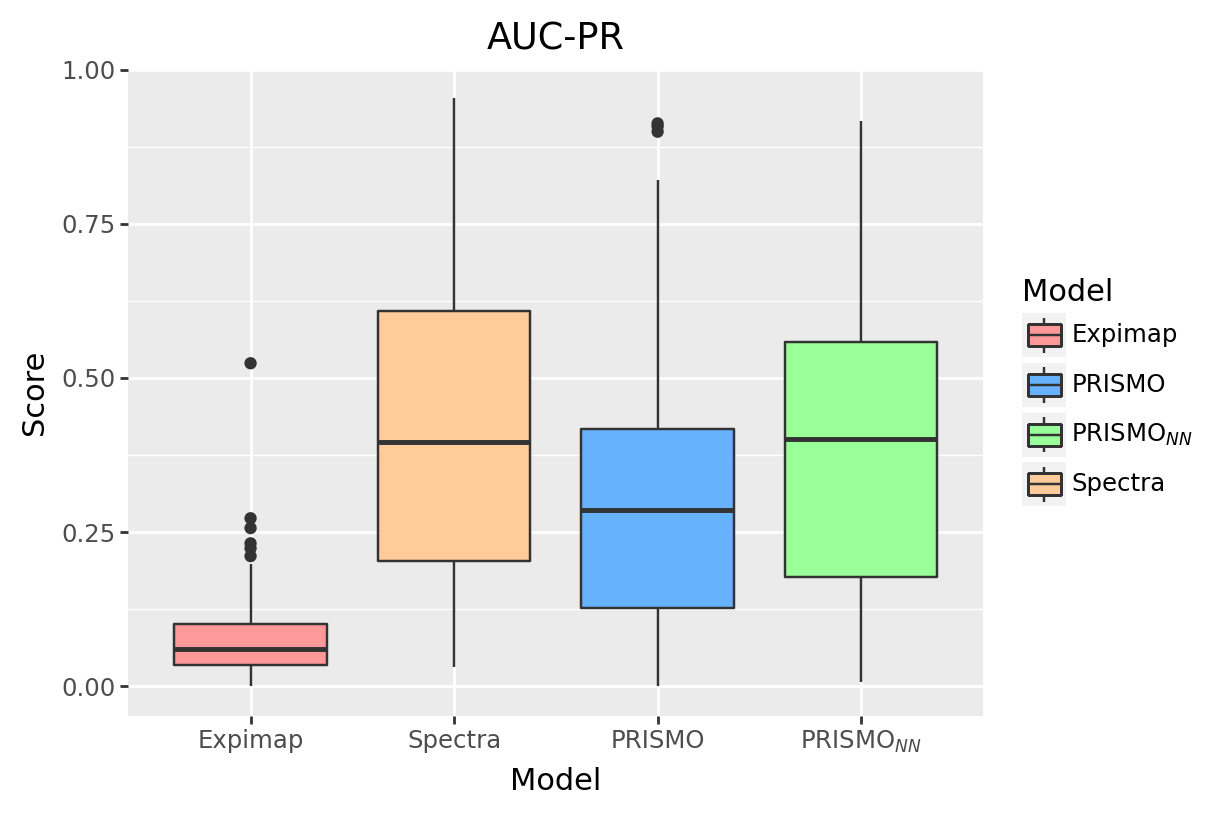

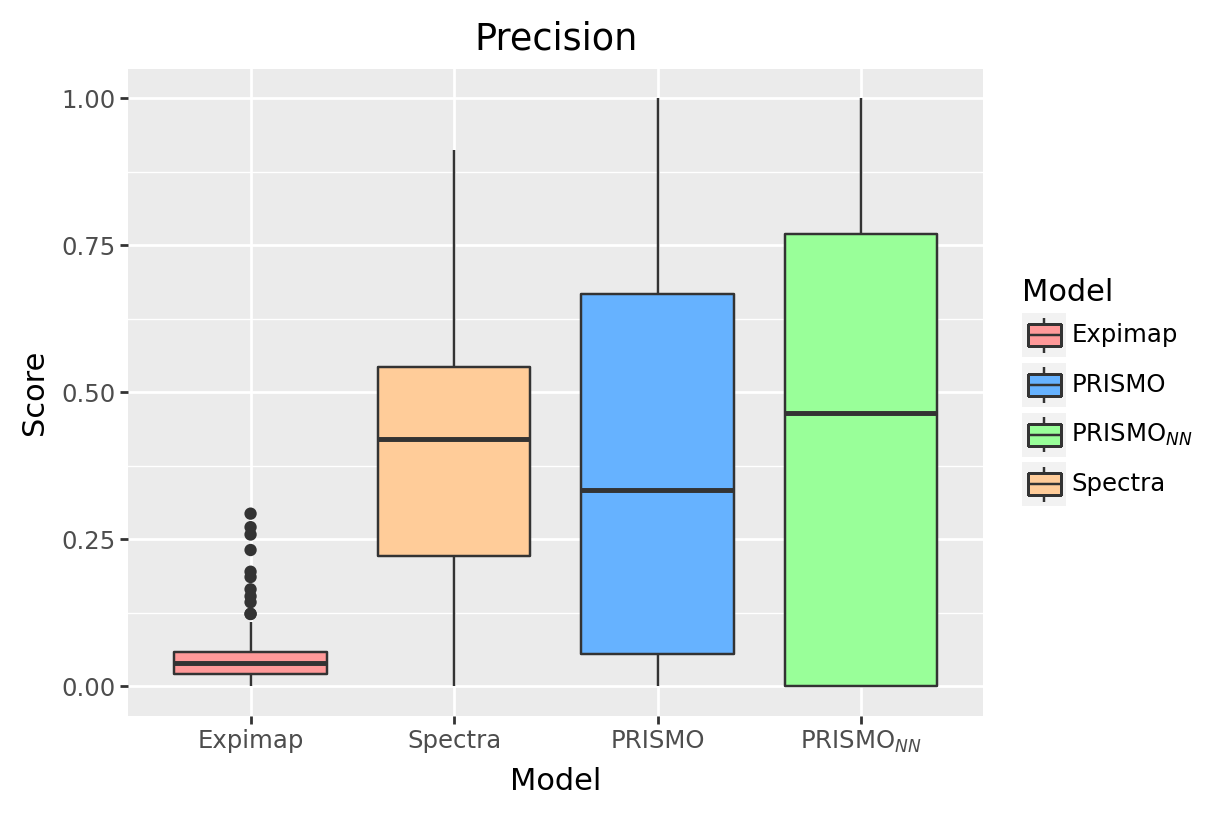

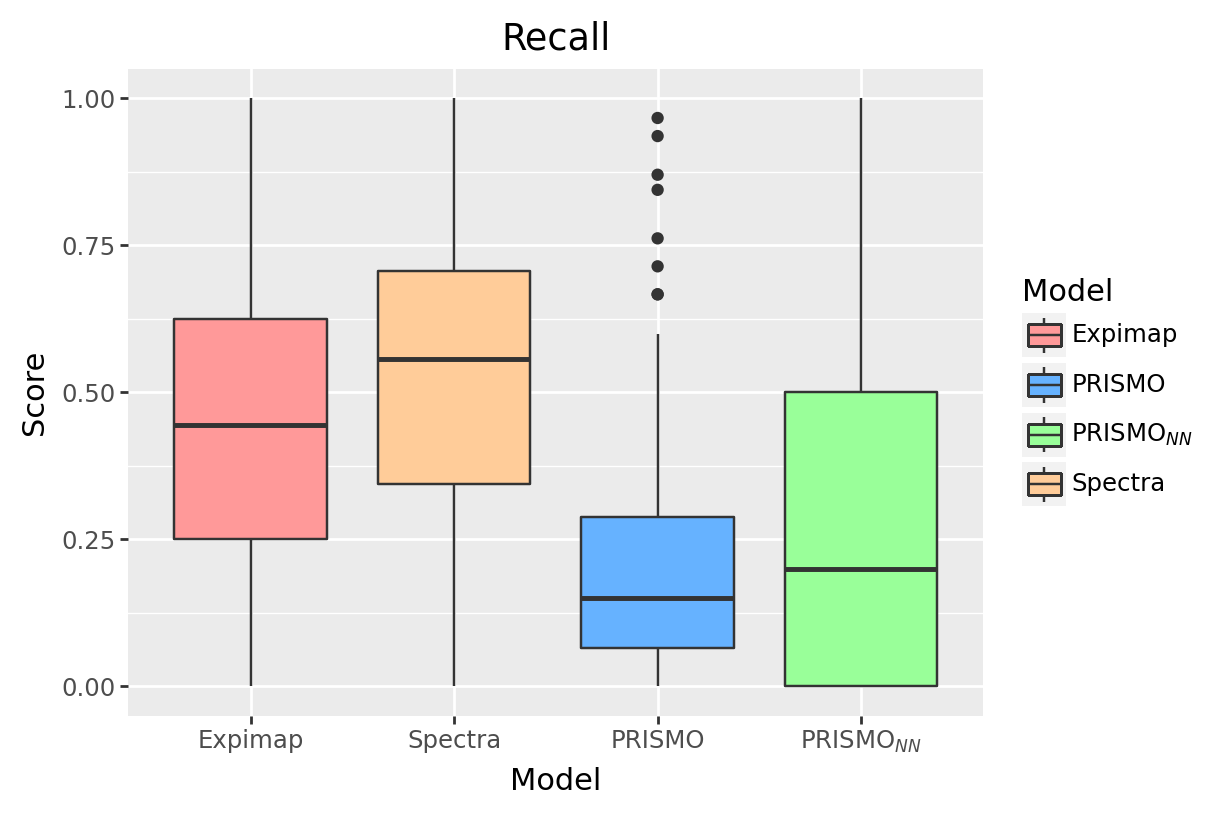

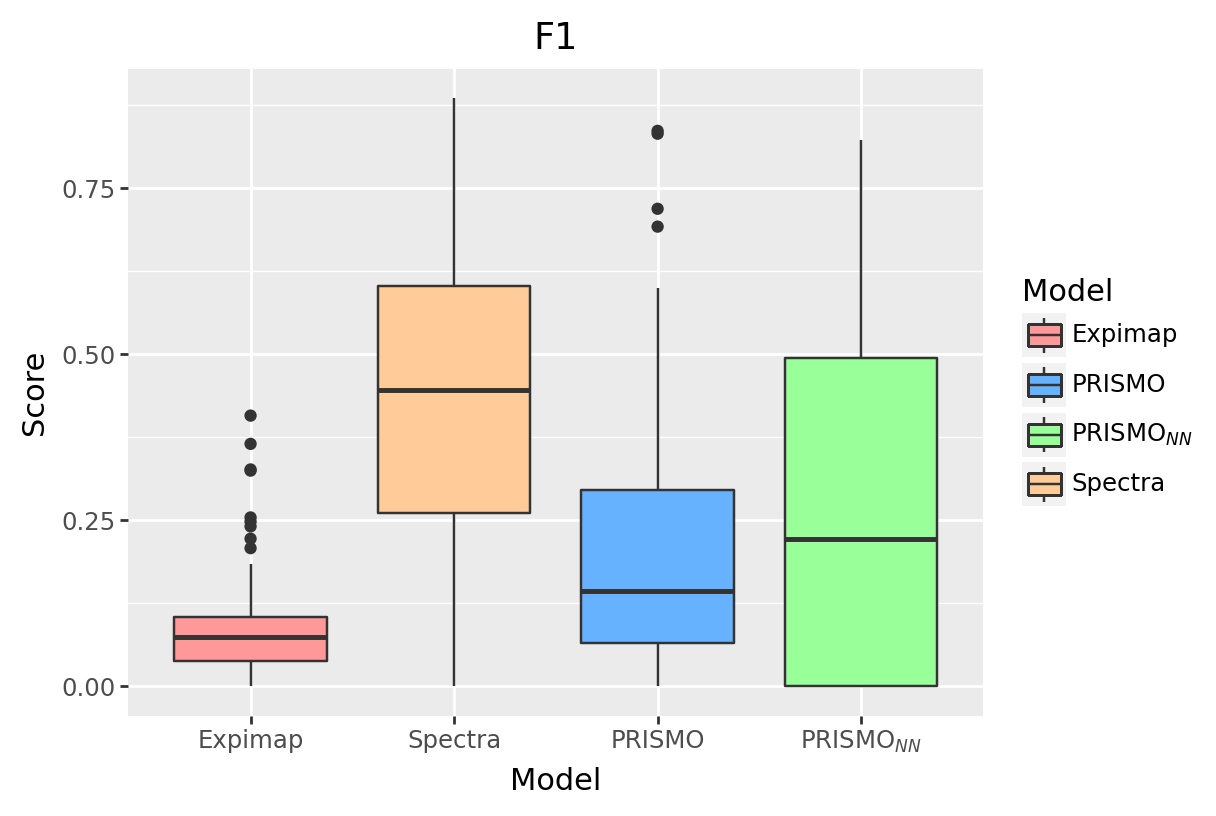

In [13]:
score_df_dict = {
    "AUC-PR": pd.DataFrame(per_factor_aupr),
    "Precision": pd.DataFrame(per_factor_prec),
    "Recall": pd.DataFrame(per_factor_rec),
    "F1": pd.DataFrame(per_factor_f1),
}

# Rename columns
import copy
score_df_dict_new_names = copy.deepcopy(score_df_dict)
for score_name, score_df in score_df_dict_new_names.items():
    score_df.columns = [
        "Expimap",
        "Spectra",
        "PRISMO",
        "PRISMO$_{NN}$",
    ]


def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    for score_name, score_df in score_df_dict.items():
        if model_names is not None:
            score_df = score_df.loc[:, model_names]

        df_long = score_df.melt(var_name="Model", value_name="Score")
        df_long["Metric"] = score_name

        p = (
            ggplot(df_long, aes(x="Model", y="Score", fill="Model"))
            + geom_boxplot(**boxplot_kwargs)
            + labs(title=score_name)
            + scale_fill_manual(values=colors_disc[: len(score_df.columns)])
            + theme(axis_text_x=element_text(**xticklabels_kwargs), figure_size=(6, 4))
            # Sort x axis by Expimap, Specta, Prismo and Prismo NMF
            + scale_x_discrete(
                limits=[
                    "Expimap",
                    "Spectra",
                    "PRISMO",
                    "PRISMO$_{NN}$",
                ]
            )
        )

        if ylim is not None:
            p = p + ylim(ylim[0], ylim[1])

        if model_labels is not None:
            p = p + scale_x_discrete(labels=model_labels)

        p.show()


plot_scores(score_df_dict_new_names)

In [14]:
score_df_dict["AUC-PR"].median()

expimap       0.059566
spectra       0.396300
prismo        0.285858
prismo_nmf    0.400587
dtype: float64

In [15]:
model_scores = {}
for k, model in model_dict.items():
    model_scores[k] = []
    data_name = k.split("-")[0]
    if "expimap" in k:
        data_name = k.split("_")[0]

    data = data_dict[data_name]
    if "famo" in k:
        data = model.data["group_1"]["view_0"].X
    # model_scores[k].append(bm.get_rmse(model, model.data["group_1"]["view_0"].X))
    model_scores[k].append(bm.get_rmse(model, data))
    # model_scores[k].append(muvi.bm.get_average_precision(true_mask, model, top=200))
    model_scores[k].append(pd.DataFrame(per_factor_aupr).median()[k])
model_scores

{'expimap': [np.float32(0.5310243), np.float64(0.05956634984162466)],
 'spectra': [np.float32(0.7414737), np.float64(0.3963003423681696)],
 'prismo': [np.float32(0.6583003), np.float64(0.28585808156534415)],
 'prismo_nmf': [np.float32(0.5429831), np.float64(0.40058676654182274)]}

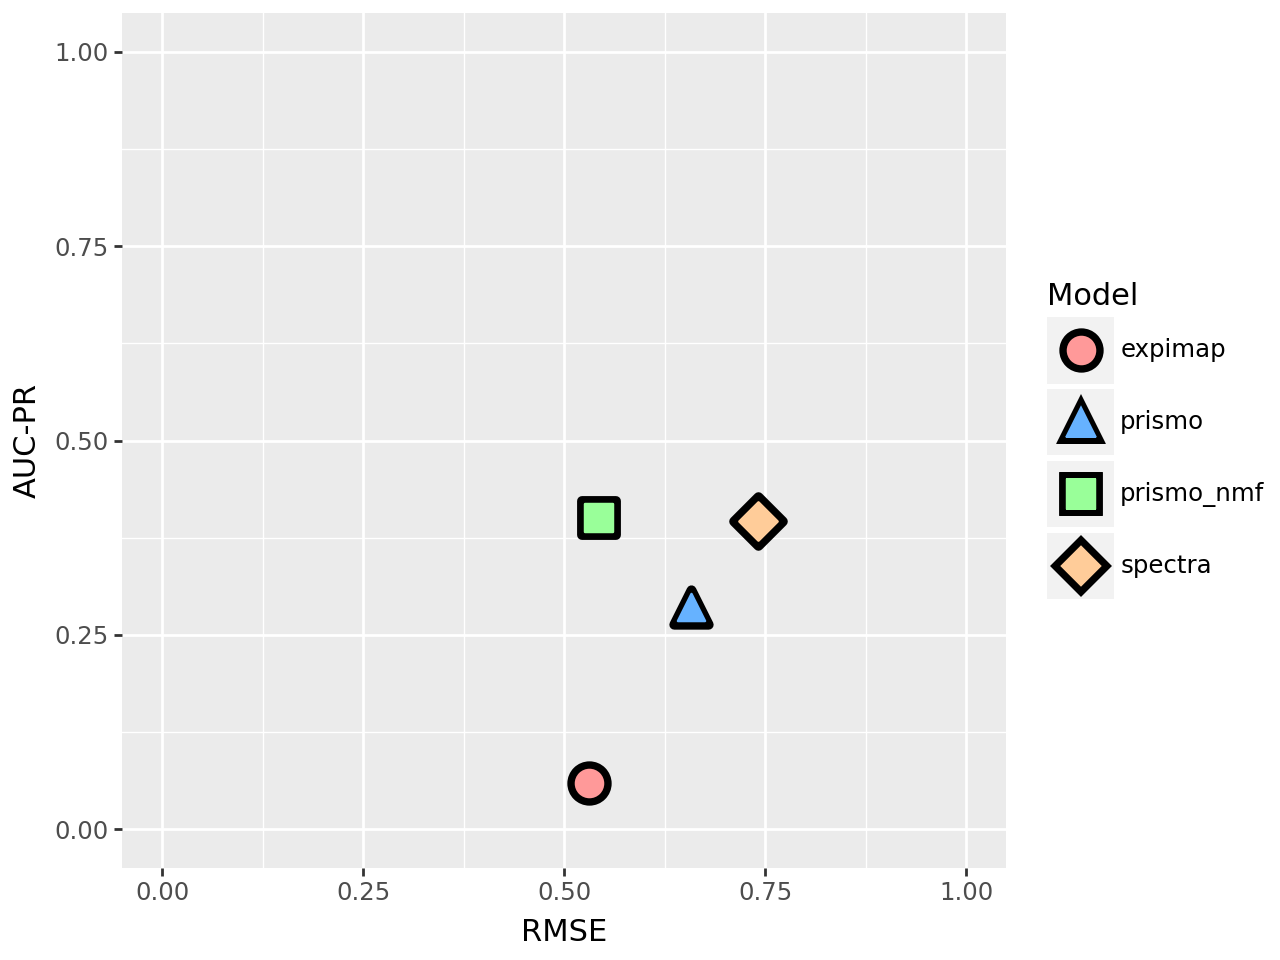

In [16]:
# Create a DataFrame
df = pd.DataFrame(model_scores).T.copy()
df.columns = ["RMSE", "AUC-PR"]
df["Model"] = df.index.copy()

# Create the plotnine plot
plot = (
    ggplot(df, aes(x="RMSE", y="AUC-PR", color="Model", shape="Model"))
    + geom_point(size=5, stroke=2, color="black", fill=None)
    + geom_point(size=5)
    + scale_color_manual(values=colors_disc)
    + xlim(0.0, 1.0)
    + ylim(0.0, 1.0)
    + theme(legend_position="right")
)
plot

In [17]:
score_df_dict

{'AUC-PR':       expimap   spectra    prismo  prismo_nmf
 0    0.025926  0.135564  0.068523    0.286652
 1    0.046276  0.085648  0.044470    0.362320
 2    0.068630  0.580092  0.035217    0.455607
 3    0.114742  0.322521  0.259757    0.274877
 4    0.080841  0.772051  0.074333    0.099514
 ..        ...       ...       ...         ...
 115  0.095679  0.267972  0.262952    0.519608
 116 -0.000000  0.605092  0.297486    0.007353
 117  0.014925  0.815405  0.259637    0.119236
 118  0.033053  0.372689  0.020921    0.285308
 119  0.523810  0.731845  0.358259    0.465467
 
 [120 rows x 4 columns],
 'Precision':       expimap   spectra    prismo  prismo_nmf
 0    0.011628  0.178571  0.000000    0.000000
 1    0.051948  0.083333  0.048780    0.500000
 2    0.042553  0.342105  0.039216    0.250000
 3    0.077778  0.375000  0.162791    0.363636
 4    0.031746  0.641026  0.060000    0.046296
 ..        ...       ...       ...         ...
 115  0.017857  0.297297  0.666667    1.000000
 116  0.00

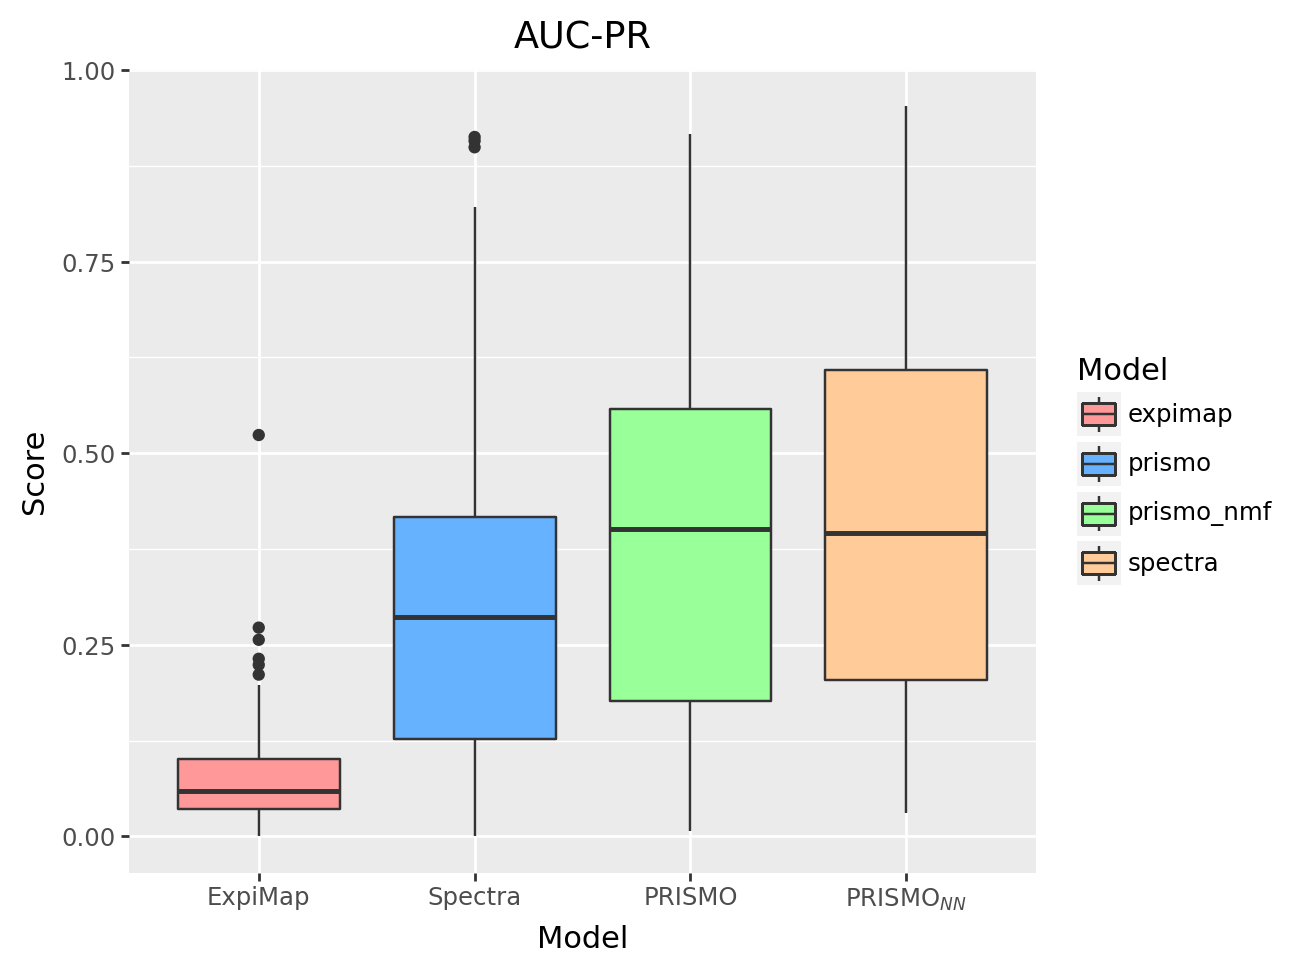

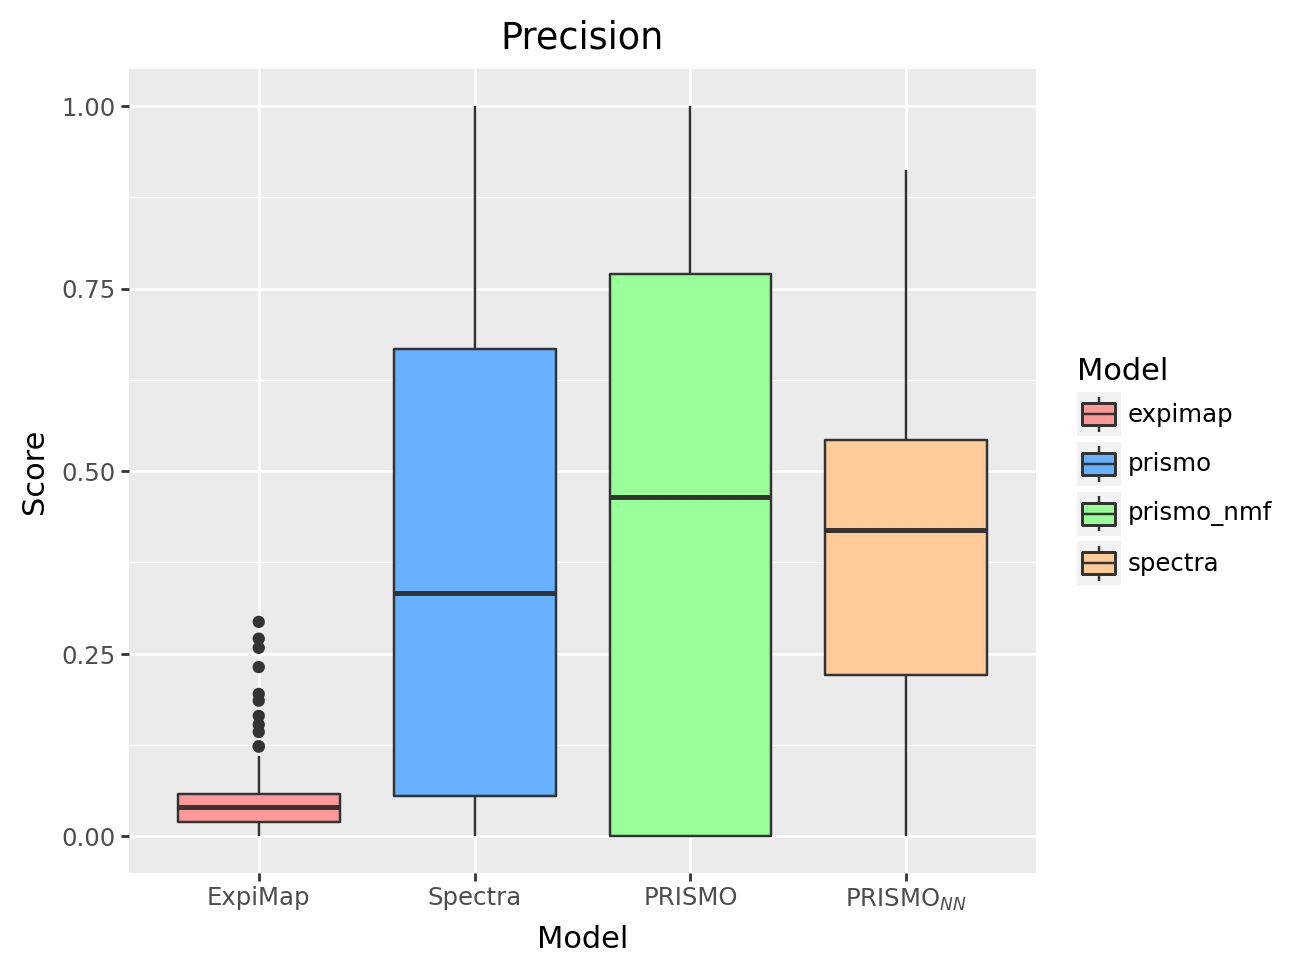

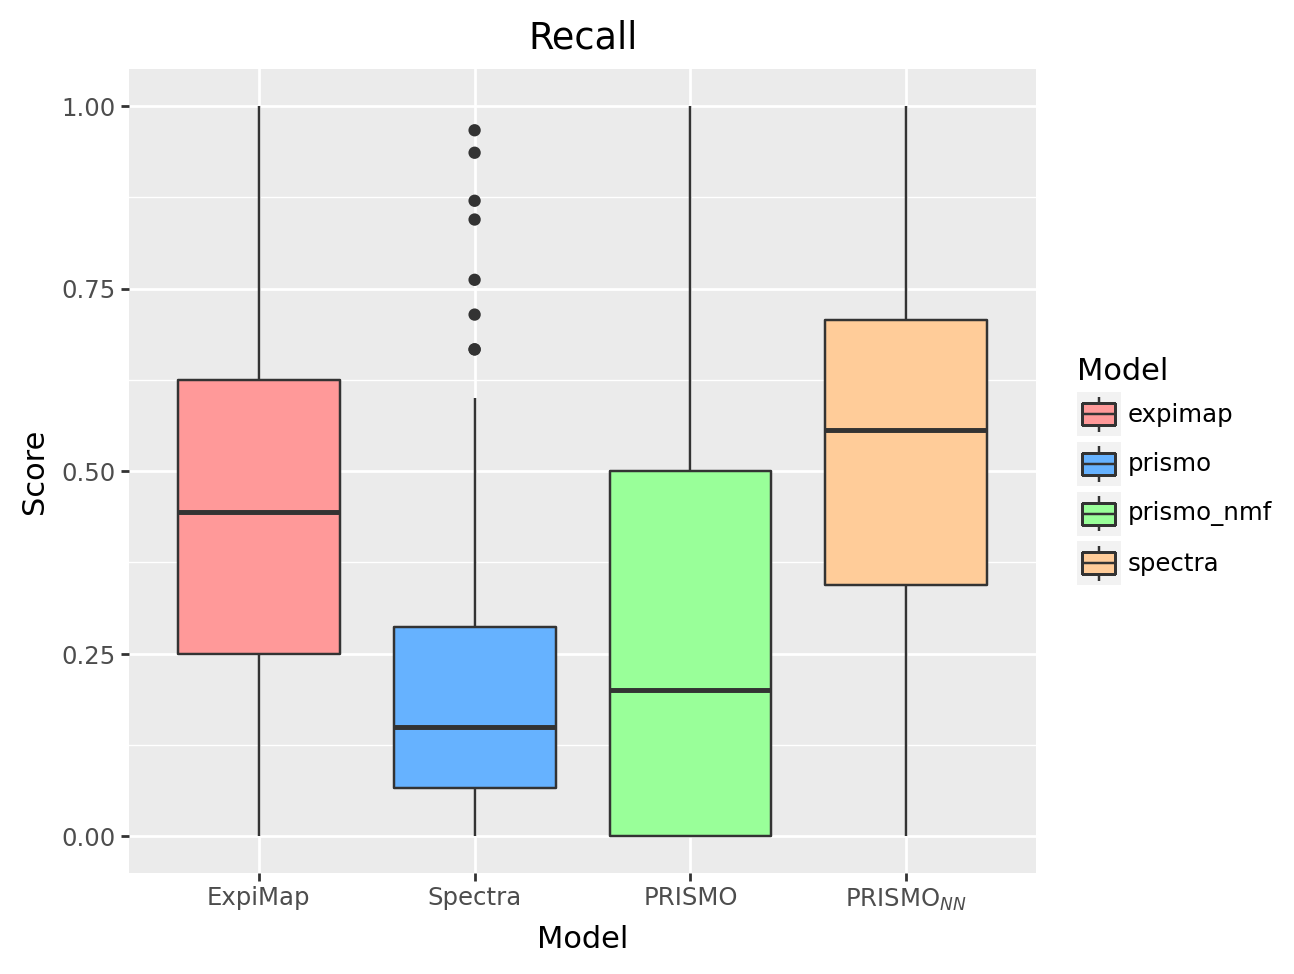

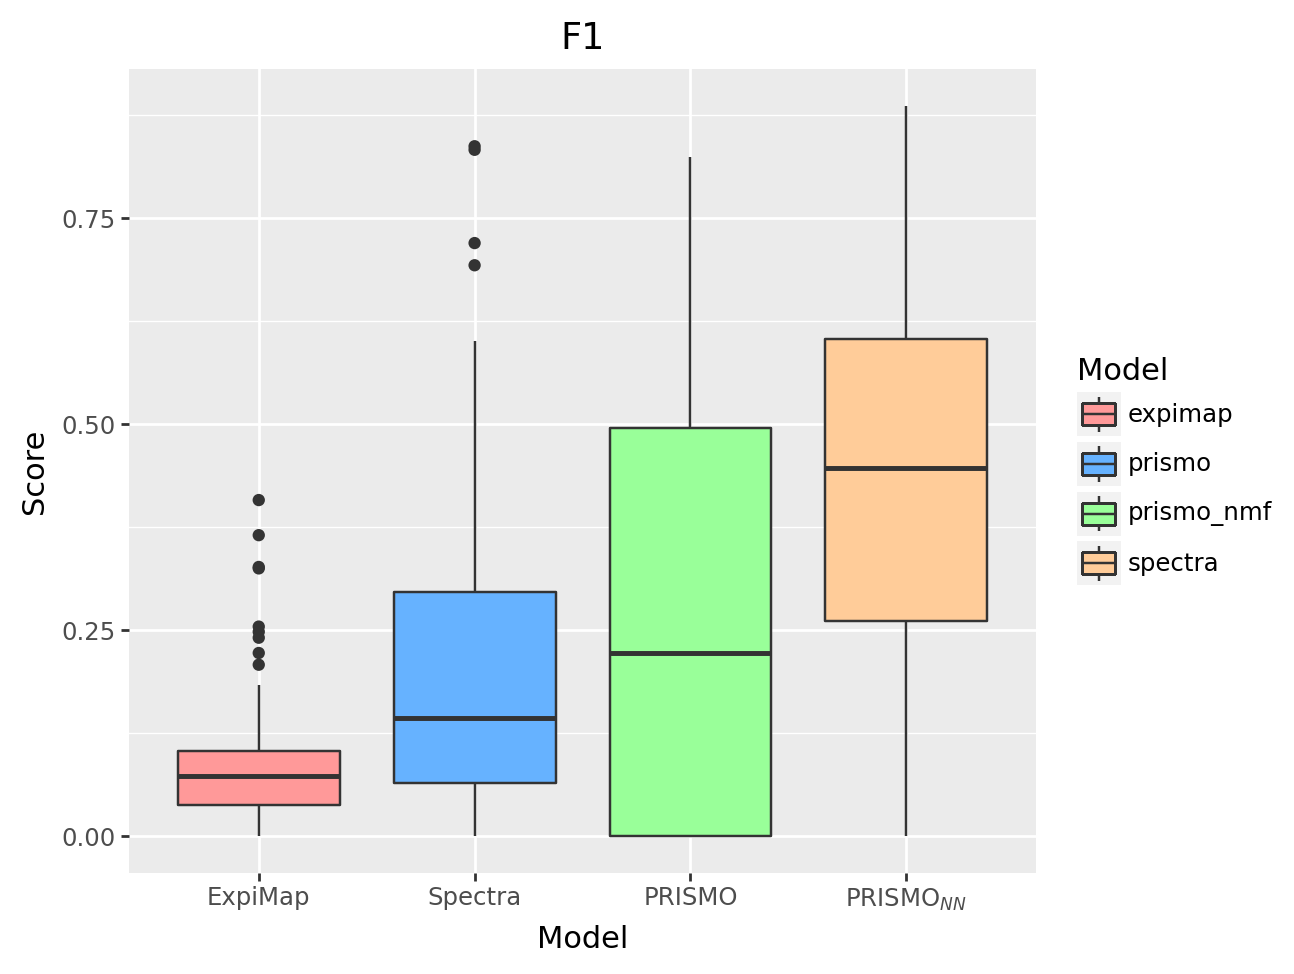

index       Model     Score
0        0     expimap  0.021739
1        1     expimap  0.096386
2        2     expimap  0.076190
3        3     expimap  0.134615
4        4     expimap  0.056338
..     ...         ...       ...
475    115  prismo_nmf  0.666667
476    116  prismo_nmf  0.000000
477    117  prismo_nmf  0.181818
478    118  prismo_nmf  0.222222
479    119  prismo_nmf  0.538462

[480 rows x 3 columns]

In [18]:
model_names = ["expimap", "spectra", "prismo", "prismo_nmf"]
model_labels = ["ExpiMap", "Spectra", "PRISMO", "PRISMO$_{NN}$"]


def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    for score_name, score_df in score_df_dict.items():
        if model_names is not None:
            score_df = score_df.loc[:, model_names]

        melted_df = pd.melt(
            score_df.reset_index(),
            id_vars=["index"],
            var_name="Model",
            value_name="Score",
        )

        p = (
            ggplot(melted_df, aes(x="Model", y="Score", fill="Model"))
            + geom_boxplot(**boxplot_kwargs)
            + ggtitle(score_name)
            + theme(axis_text_x=element_text(**xticklabels_kwargs))
        )

        if colors_disc is not None:
            p += scale_fill_manual(values=colors_disc)

        if ylim is not None:
            p += ylim(*ylim)

        if model_labels is not None:
            p += scale_x_discrete(labels=model_labels)

        p.show()

    return melted_df


plot_scores(score_df_dict, model_names, model_labels)

In [19]:
factor_loadings = {k: bm.get_factor_loadings(model) for k, model in model_dict.items()}
factor_loadings.keys()

dict_keys(['expimap', 'spectra', 'prismo', 'prismo_nmf'])

In [20]:
fn_sum = (true_mask & ~noisy_mask).sum(axis=1)

In [21]:
np.set_printoptions(precision=1)

In [22]:
idx_df = {}
tp_df = {}
tn_df = {}
fp_df = {}
fn_df = {}
for k, model in model_dict.items():
    idx, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    idx_df[k] = idx
    non_zero = np.abs(wh) > 0.0
    tp = tm & nm & non_zero
    tn = ~tm & ~nm & non_zero
    fp = ~tm & nm & non_zero
    fn = tm & ~nm & non_zero
    tp_df[k] = tp.sum(axis=1).tolist()
    tn_df[k] = tn.sum(axis=1).tolist()
    fp_df[k] = fp.sum(axis=1).tolist()
    fn_df[k] = fn.sum(axis=1).tolist()
    if len(k) < 5:
        k += "\t"
    print(
        k,
        "\t",
        "TP, FP, TN, FN",
        "\t",
        f"{tp.sum(axis=1).mean():2.2f}, {fp.sum(axis=1).mean():2.2f}, {tn.sum(axis=1).mean():2.2f}, {fn.sum(axis=1).mean():2.2f}",
    )
tp_df = pd.DataFrame(tp_df)
tn_df = pd.DataFrame(tn_df)
fp_df = pd.DataFrame(fp_df)
fn_df = pd.DataFrame(fn_df)

expimap 	 TP, FP, TN, FN 	 6.43, 0.91, 189.93, 2.73
spectra 	 TP, FP, TN, FN 	 32.96, 19.71, 145.93, 1.41
prismo 	 TP, FP, TN, FN 	 21.73, 4.92, 170.84, 2.51
prismo_nmf 	 TP, FP, TN, FN 	 11.30, 1.49, 183.72, 3.48


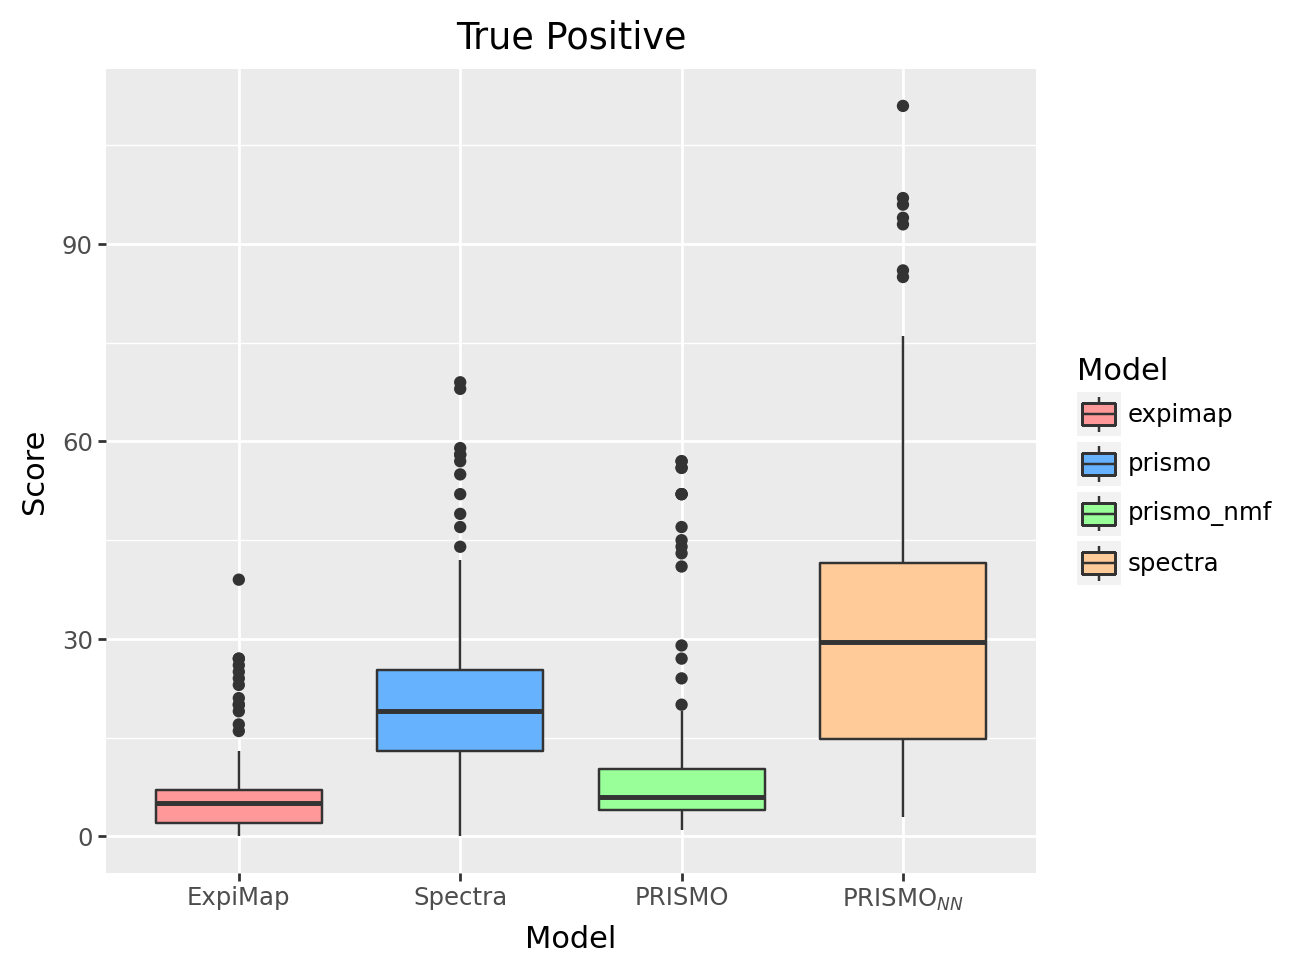

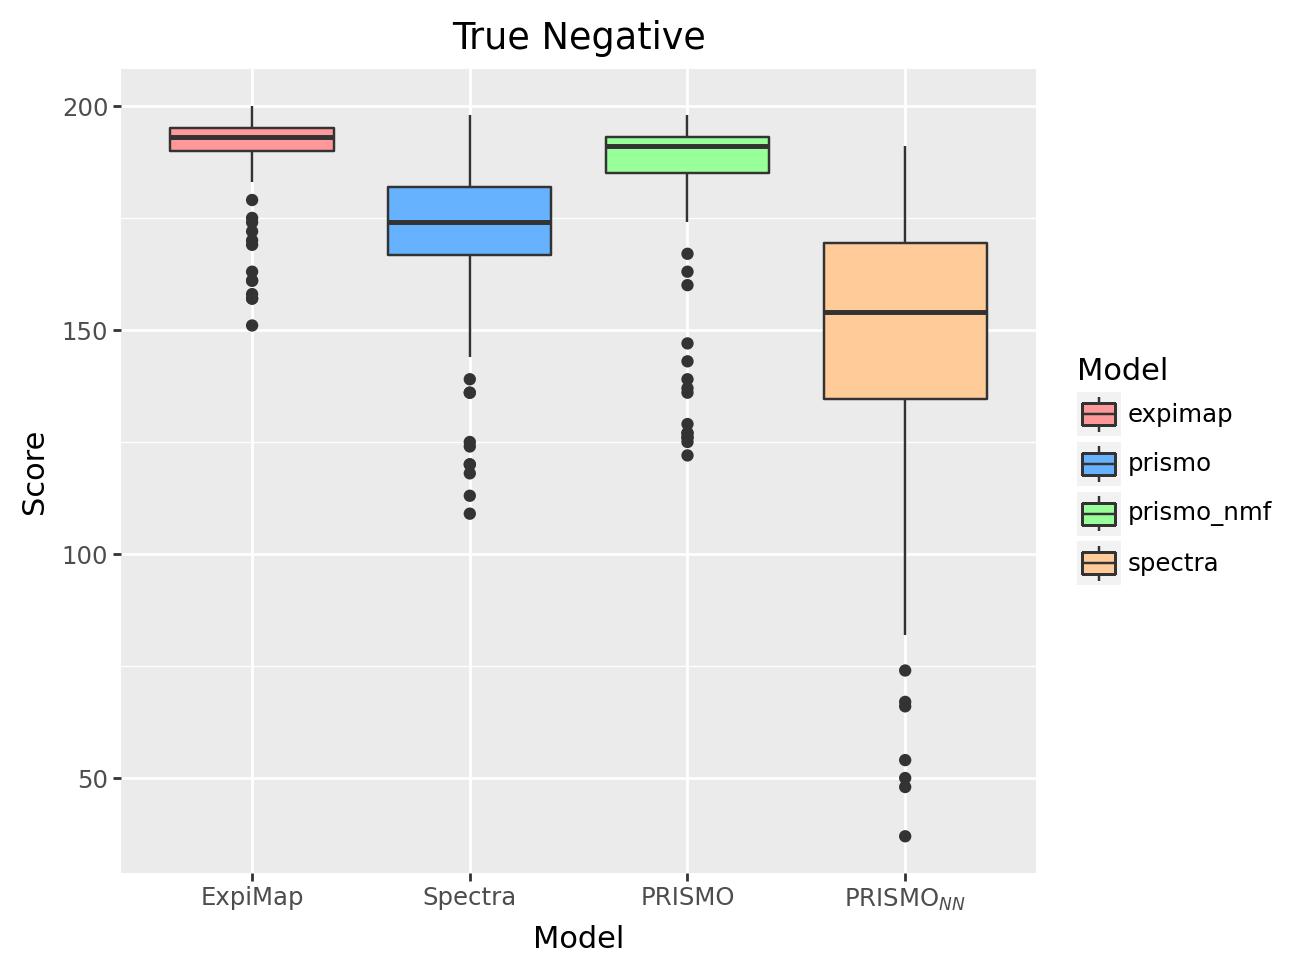

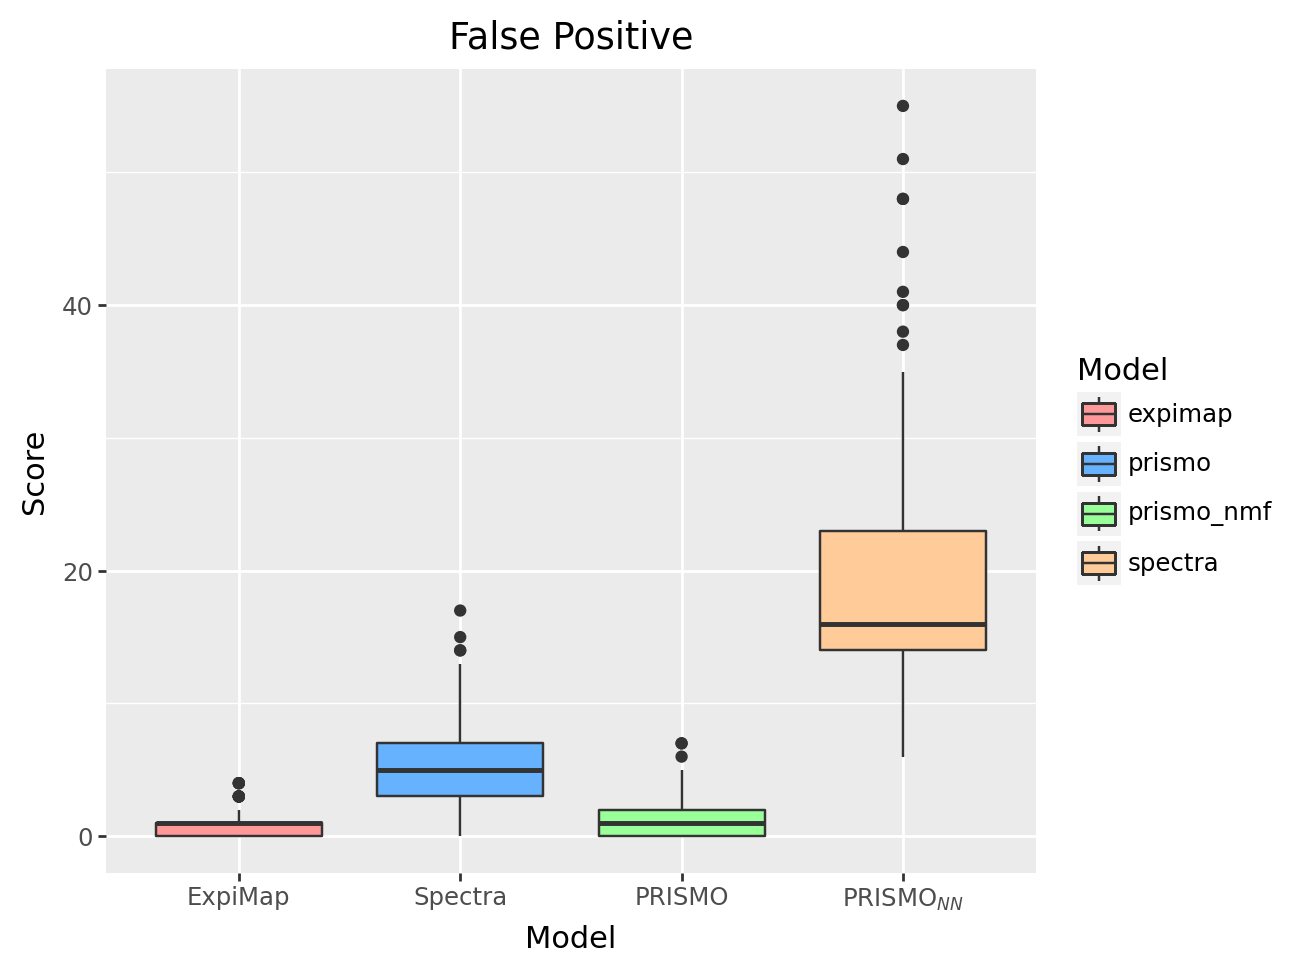

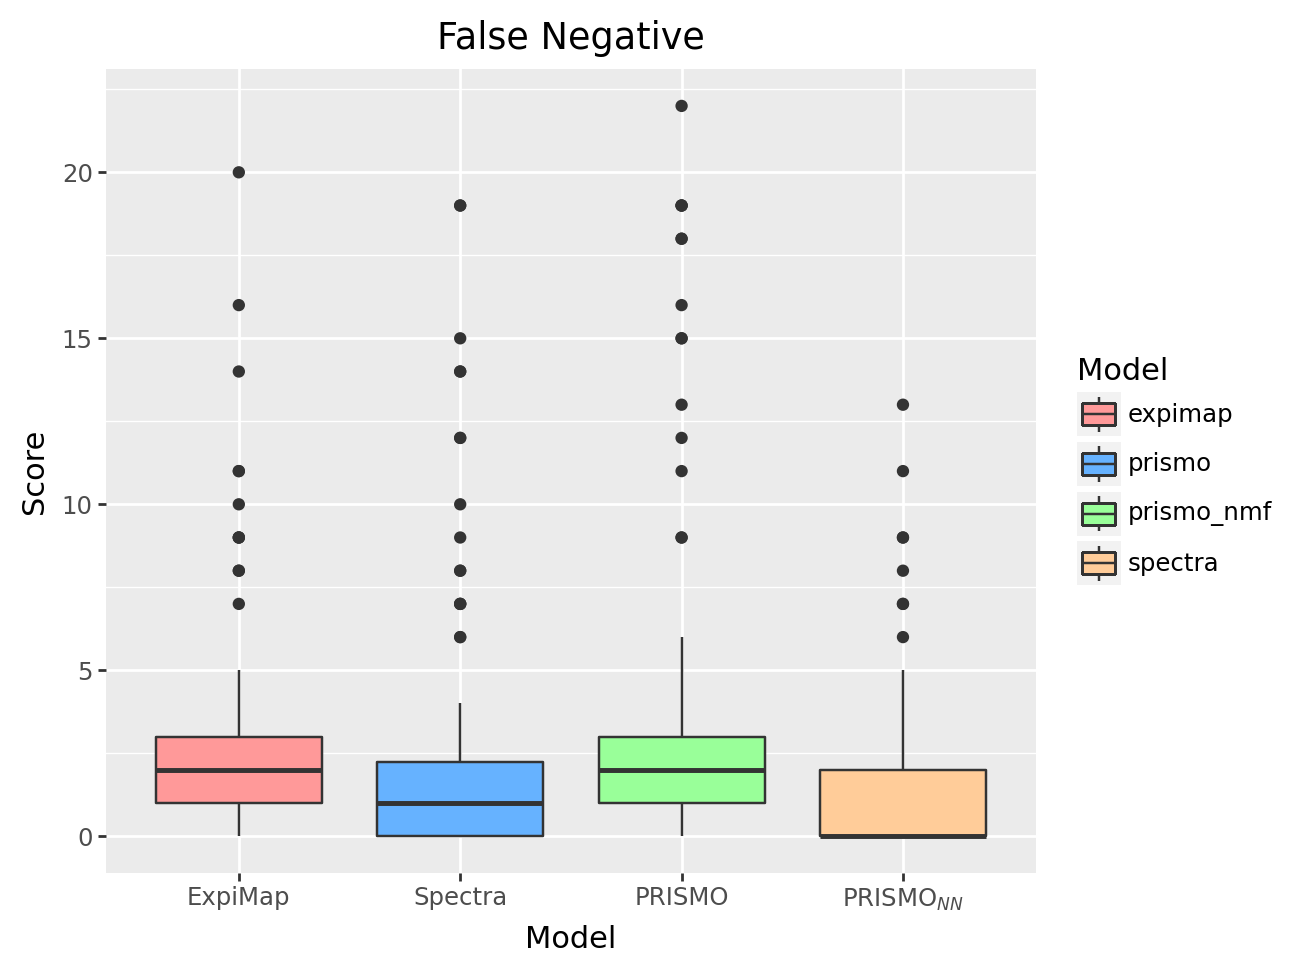

index       Model  Score
0        0     expimap      2
1        1     expimap      2
2        2     expimap      2
3        3     expimap      1
4        4     expimap      1
..     ...         ...    ...
475    115  prismo_nmf      1
476    116  prismo_nmf      0
477    117  prismo_nmf      3
478    118  prismo_nmf      3
479    119  prismo_nmf      6

[480 rows x 3 columns]

In [23]:
plot_scores(
    {
        "True Positive": tp_df,
        "True Negative": tn_df,
        "False Positive": fp_df,
        "False Negative": fn_df,
    },
    model_names,
    model_labels,
)
# plot_scores(
#     {"False Positive": fp_df, "False Negative": fn_df}, model_names, model_labels
# )

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 120 rows containing missing values.


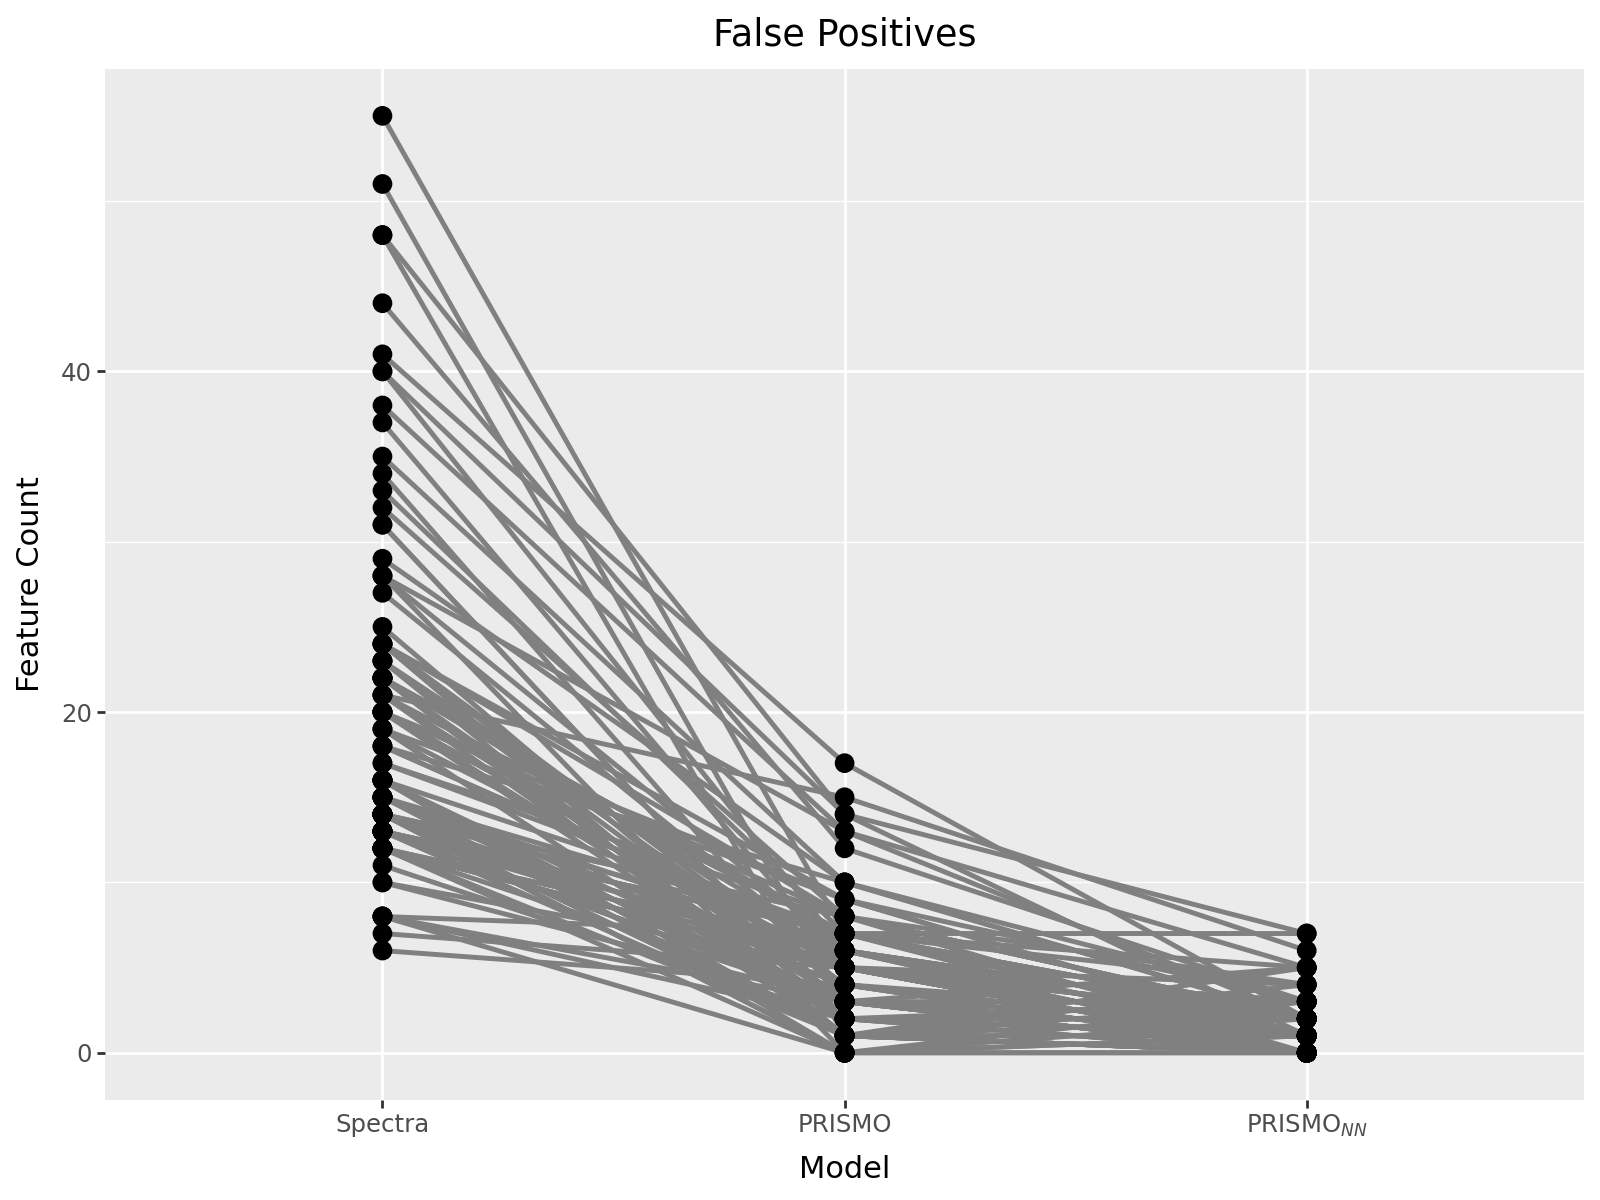

In [24]:
model_cols = model_names
point_df = fp_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    ggplot(point_df, aes(x="Model", y="Feature Count", group="factor"))
    + geom_line(alpha=1.0, color="gray", size=1)
    + geom_point(alpha=1.0, color="black", size=3)
    + ggtitle("False Positives")
    + theme(figure_size=(8, 6))
    + scale_x_discrete(
        limits=[
            "Spectra",
            "PRISMO",
            "PRISMO$_{NN}$",
        ]
    )
)

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 120 rows containing missing values.


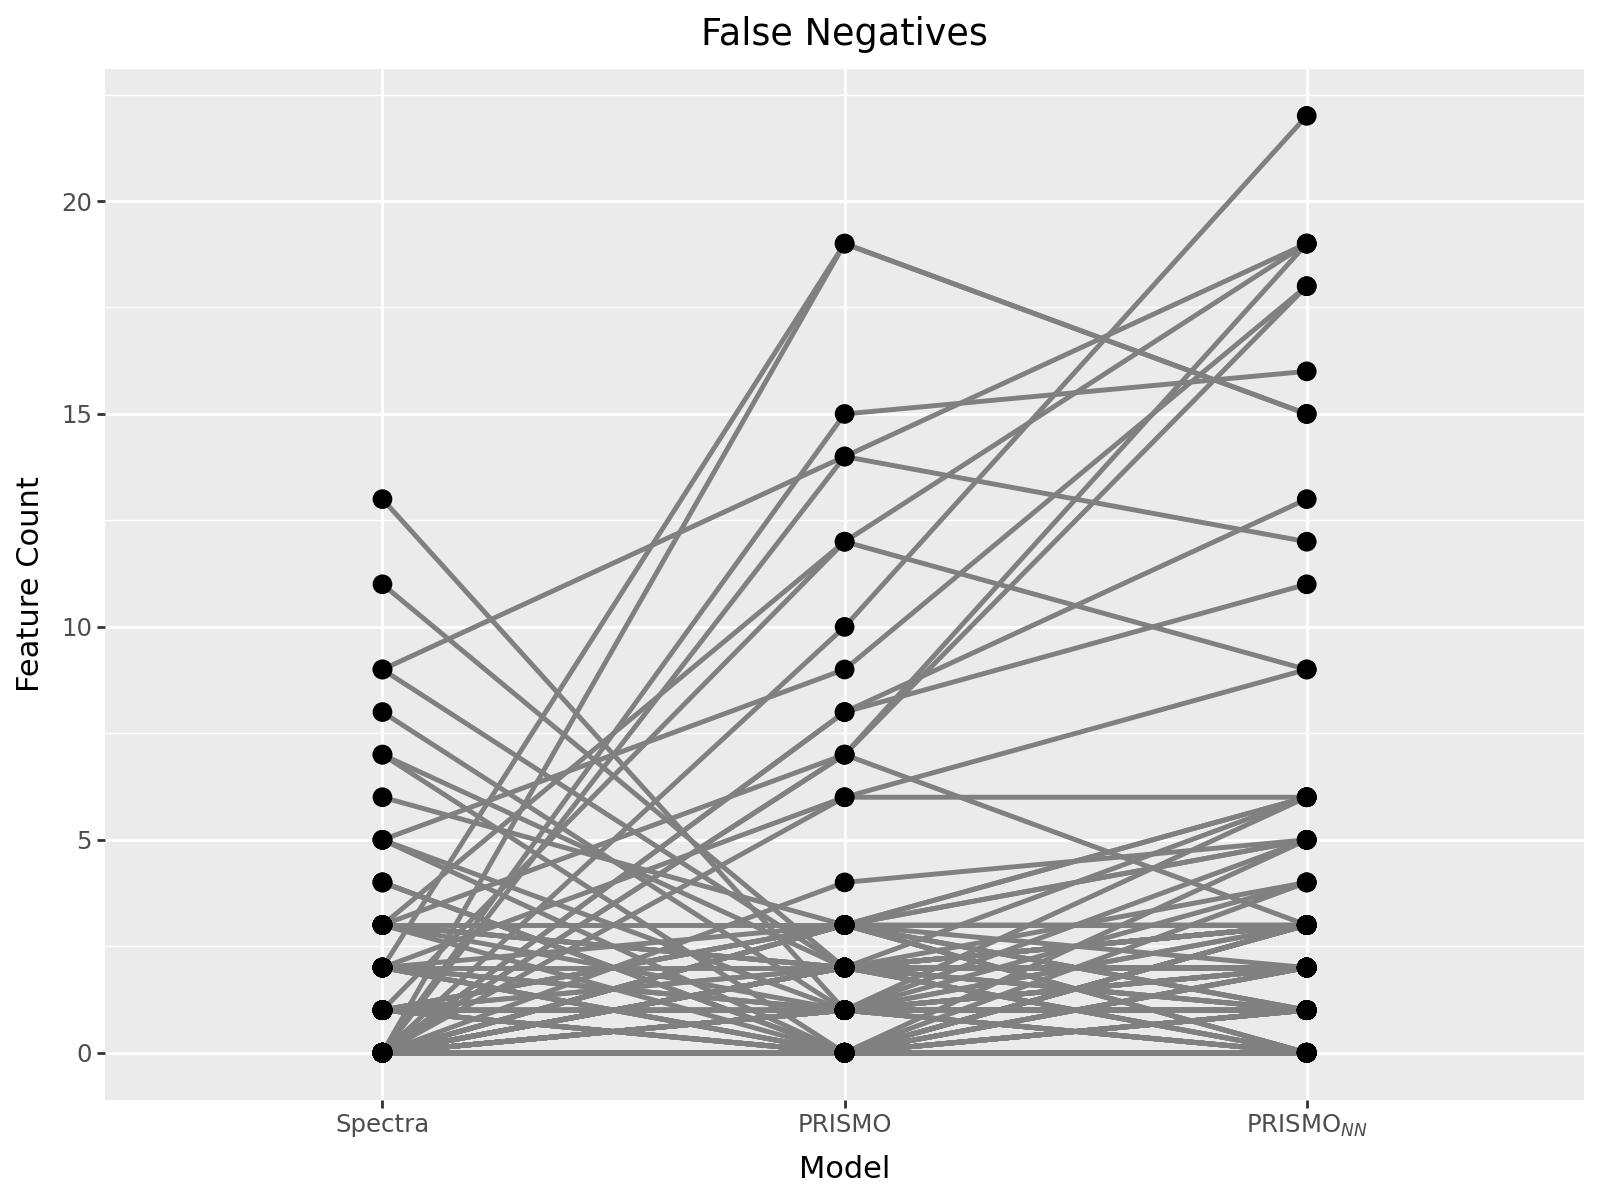

In [25]:
model_cols = model_names
point_df = fn_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    ggplot(point_df, aes(x="Model", y="Feature Count", group="factor"))
    + geom_line(alpha=1.0, color="gray", size=1)
    + geom_point(alpha=1.0, color="black", size=3)
    + ggtitle("False Negatives")
    + theme(figure_size=(8, 6))
    + scale_x_discrete(
        limits=[
            "Spectra",
            "PRISMO",
            "PRISMO$_{NN}$",
        ]
    )
)

In [26]:
for top in [50, 100, 200, 500]:
    top_overlap_dict = {}
    for k in range(true_mask.shape[0]):
        d = None
        for mn, v in idx_df.items():
            if "nmf" in mn:
                continue
            s = set(v[k, :top])
            if d is None:
                d = s
            else:
                d &= s
        top_overlap_dict[terms[k]] = adata.var_names[sorted(d)]
    print("DONE")

DONE
DONE
DONE
DONE


In [27]:
[(i, t) for i, t in enumerate(terms) if "INTERFERON" in t]

[(26, 'REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA'),
 (49, 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'),
 (50, 'REACTOME_INTERFERON_GAMMA_SIGNALING'),
 (51, 'REACTOME_INTERFERON_SIGNALING')]

In [28]:
[(i, t) for i, t in enumerate(terms) if "B_CELL" in t]

[(34, 'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'),
 (99, 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR')]

In [29]:
pd.DataFrame(per_factor_aupr).loc[[49, 50, 51], :]

expimap   spectra    prismo  prismo_nmf
49  0.053837  0.808532  0.576011    0.517180
50  0.151070  0.768601  0.088201    0.128263
51  0.090851  0.621813  0.570568    0.535267

In [30]:
pd.DataFrame(per_factor_aupr).loc[[99], :]

expimap   spectra   prismo  prismo_nmf
99  0.074147  0.265558  0.38651    0.063988

In [31]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "INTERFERON" in t]

[(29,
  np.str_('REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA')),
 (52, np.str_('REACTOME_INTERFERON_ALPHA_BETA_SIGNALING')),
 (53, np.str_('REACTOME_INTERFERON_GAMMA_SIGNALING')),
 (54, np.str_('REACTOME_INTERFERON_SIGNALING'))]

In [32]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "B_CELL" in t]

[(37, np.str_('REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR')),
 (102, np.str_('REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR'))]

ROC: 0.4923637466829268


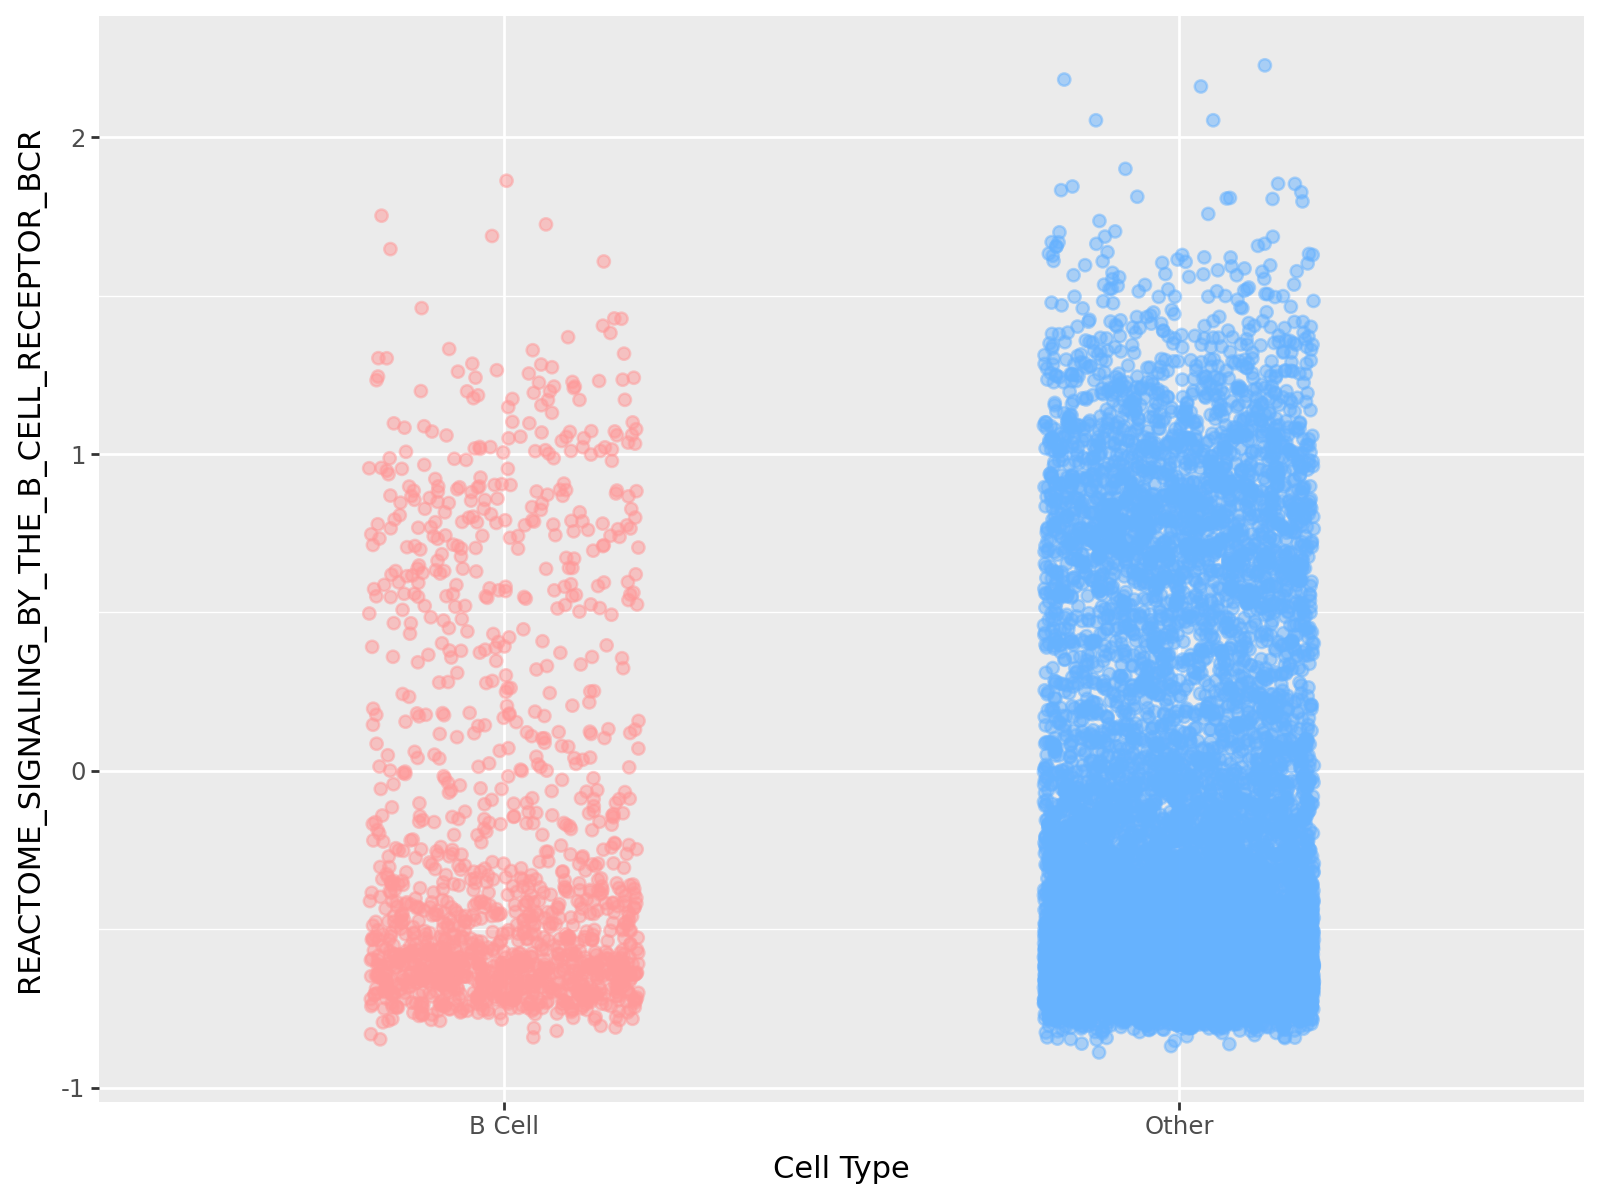

In [33]:
model_name = "prismo"
factor_name = "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
adata.obs
adata.obs["Cell Type"] = "Other"
adata.obs.loc[adata.obs["cell_type"] == "B", "Cell Type"] = "B Cell"
print("ROC:", roc_auc_score(adata.obs["Cell Type"], adata.obs[factor_name]))

(
    ggplot(adata.obs, aes(x="Cell Type", y=factor_name, color="Cell Type"))
    + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
    + scale_color_manual(values={"B Cell": colors_disc[0], "Other": colors_disc[1]})
    + scale_x_discrete(limits=["B Cell", "Other"])
    + theme(figure_size=(8, 6), legend_position="none")
)

In [34]:
adata

AnnData object with n_obs × n_vars = 13576 × 4325
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'Cell Type'

ROC: 0.9068971949758768


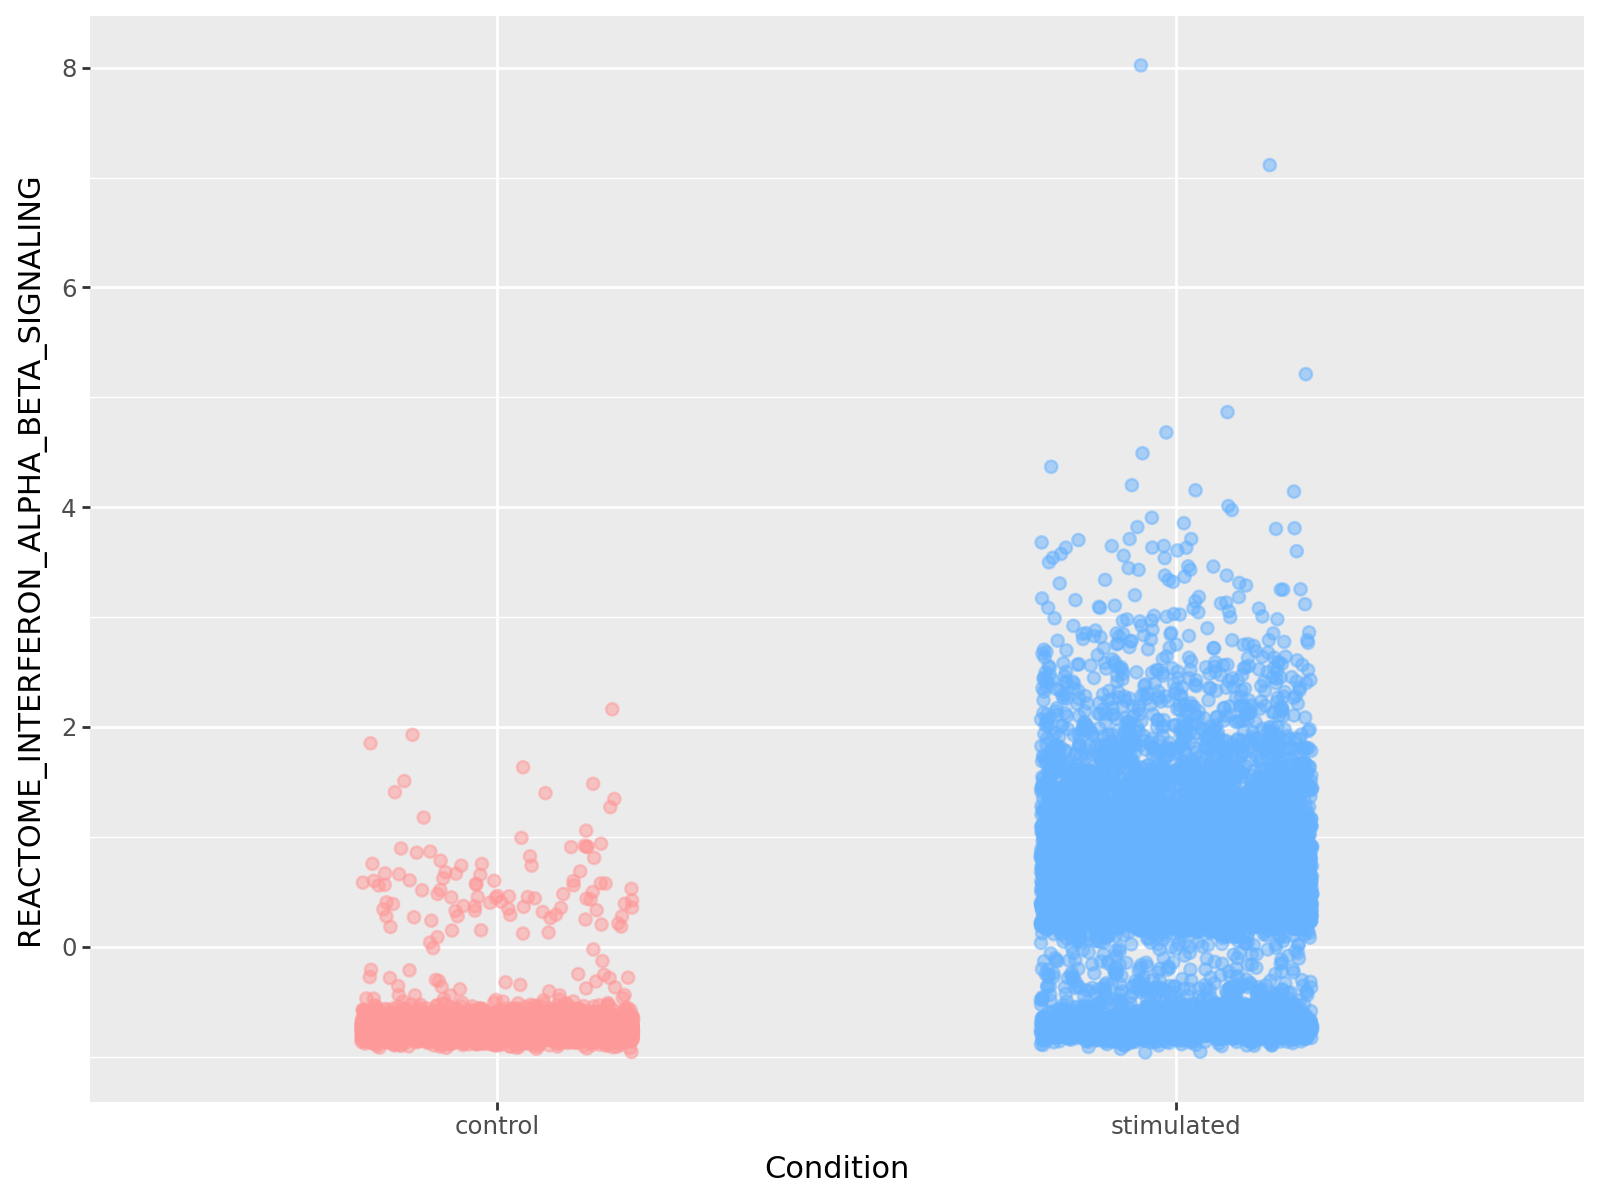

In [35]:
model_name = "prismo"
factor_name = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
print("ROC:", roc_auc_score(adata.obs["condition"], adata.obs[factor_name]))

(
    ggplot(adata.obs, aes(x="condition", y=factor_name, color="condition"))
    + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
    + scale_color_manual(
        values={"control": colors_disc[0], "stimulated": colors_disc[1]}
    )
    + theme(
        figure_size=(8, 6),
        legend_position="none",
    )
    + labs(x="Condition", y=factor_name)
)

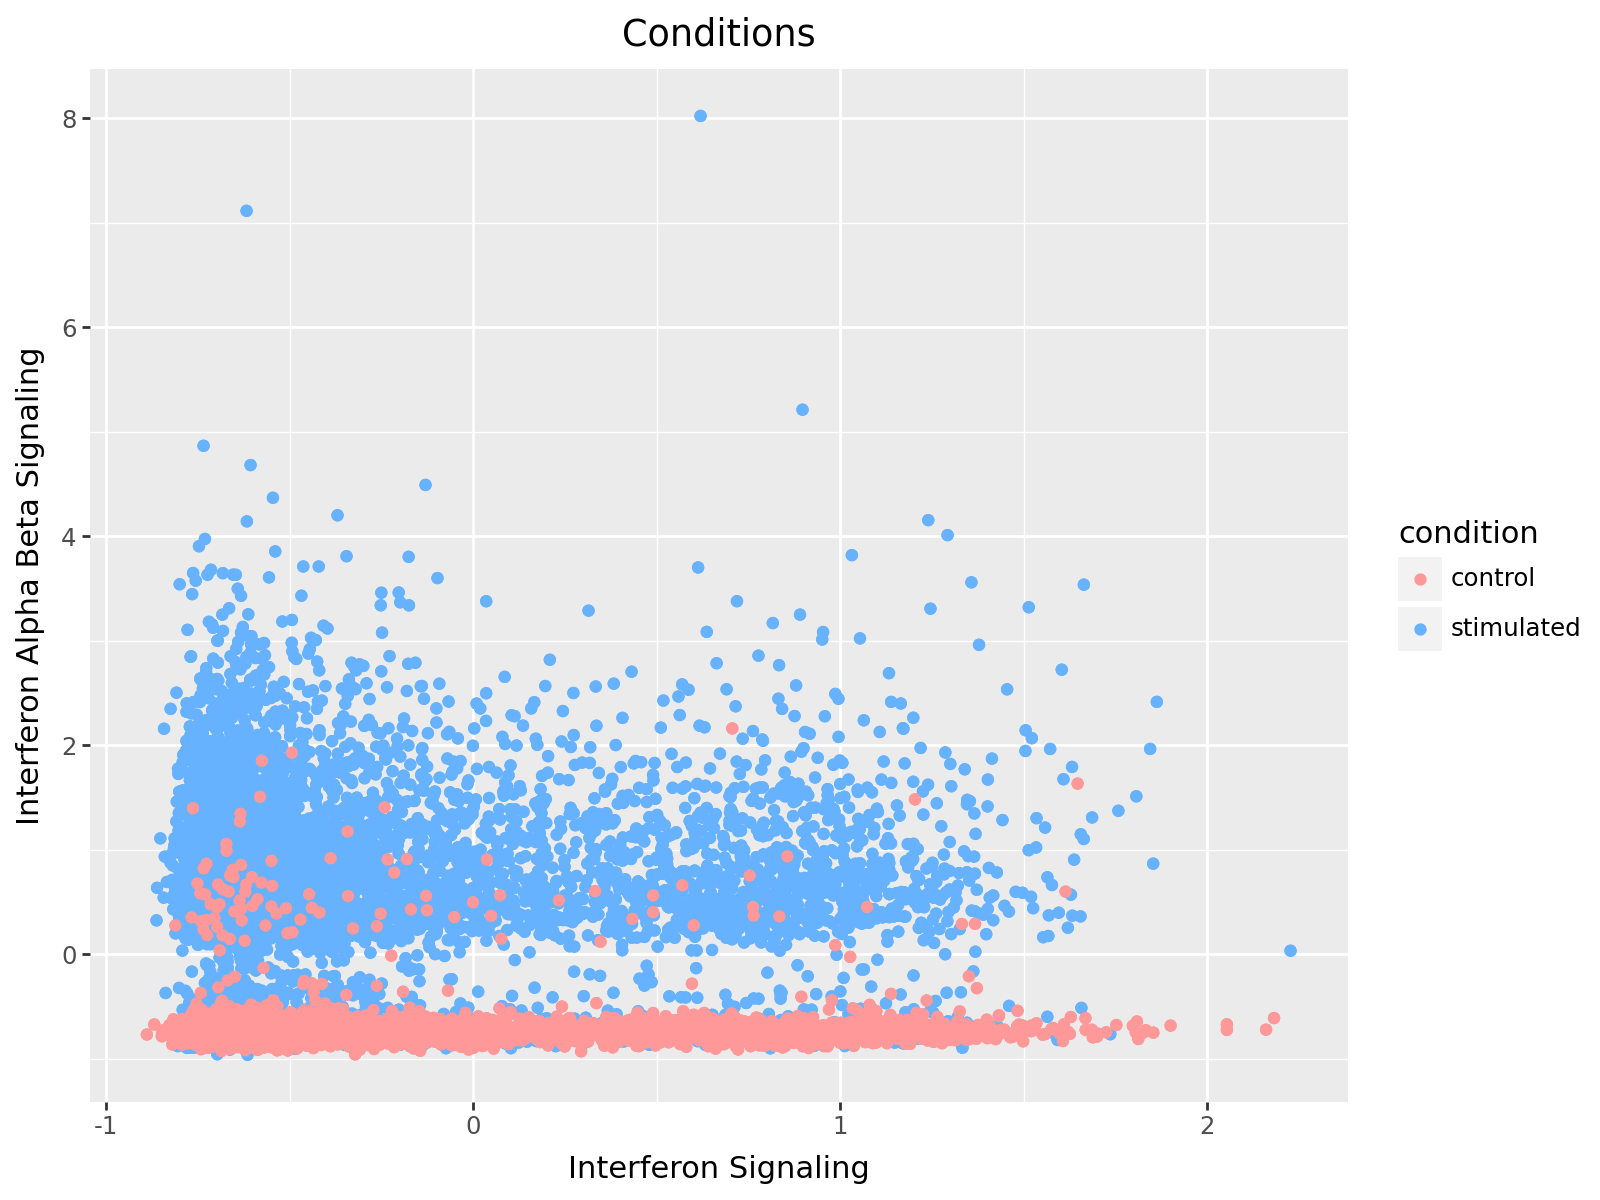

In [36]:
y = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"
x = "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"

(
    ggplot(adata.obs, aes(x=x, y=y, color="condition"))
    + geom_point()
    + scale_color_manual(
        values={"stimulated": colors_disc[1], "control": colors_disc[0], }
    )
    # First plot stimulated cells, then control cells
    + geom_point(data=adata.obs[adata.obs["condition"] == "stimulated"], color=colors_disc[1])
    + geom_point(data=adata.obs[adata.obs["condition"] == "control"], color=colors_disc[0])
    + theme(figure_size=(8, 6))
    # Change the axis labels
    + labs(x="Interferon Signaling", y="Interferon Alpha Beta Signaling")
    # Set title
    + ggtitle("Conditions")
)

In [37]:
prismo_model = model_dict["prismo"]

In [38]:
adata_latent = prismo_model.get_factors("anndata")["group_1"].copy()
adata_latent.obs = adata.obs.copy()
obs_names = adata_latent.obs_names.to_numpy()
# np.random.shuffle(obs_names)
adata_latent = adata_latent[obs_names, :].copy()
adata_latent

AnnData object with n_obs × n_vars = 13576 × 123
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'Cell Type', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'

### UMAP plots

In [39]:
sc.pp.neighbors(adata_latent, use_rep="X")
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

/tmp/ipykernel_2911606/234158693.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [40]:
df_plot = pd.DataFrame(
    {
        "x": adata_latent.obsm["X_umap"][:, 0],
        "y": adata_latent.obsm["X_umap"][:, 1],
        "cell type": adata_latent.obs["cell_type"],
        "condition": adata_latent.obs["condition"],
    }
)

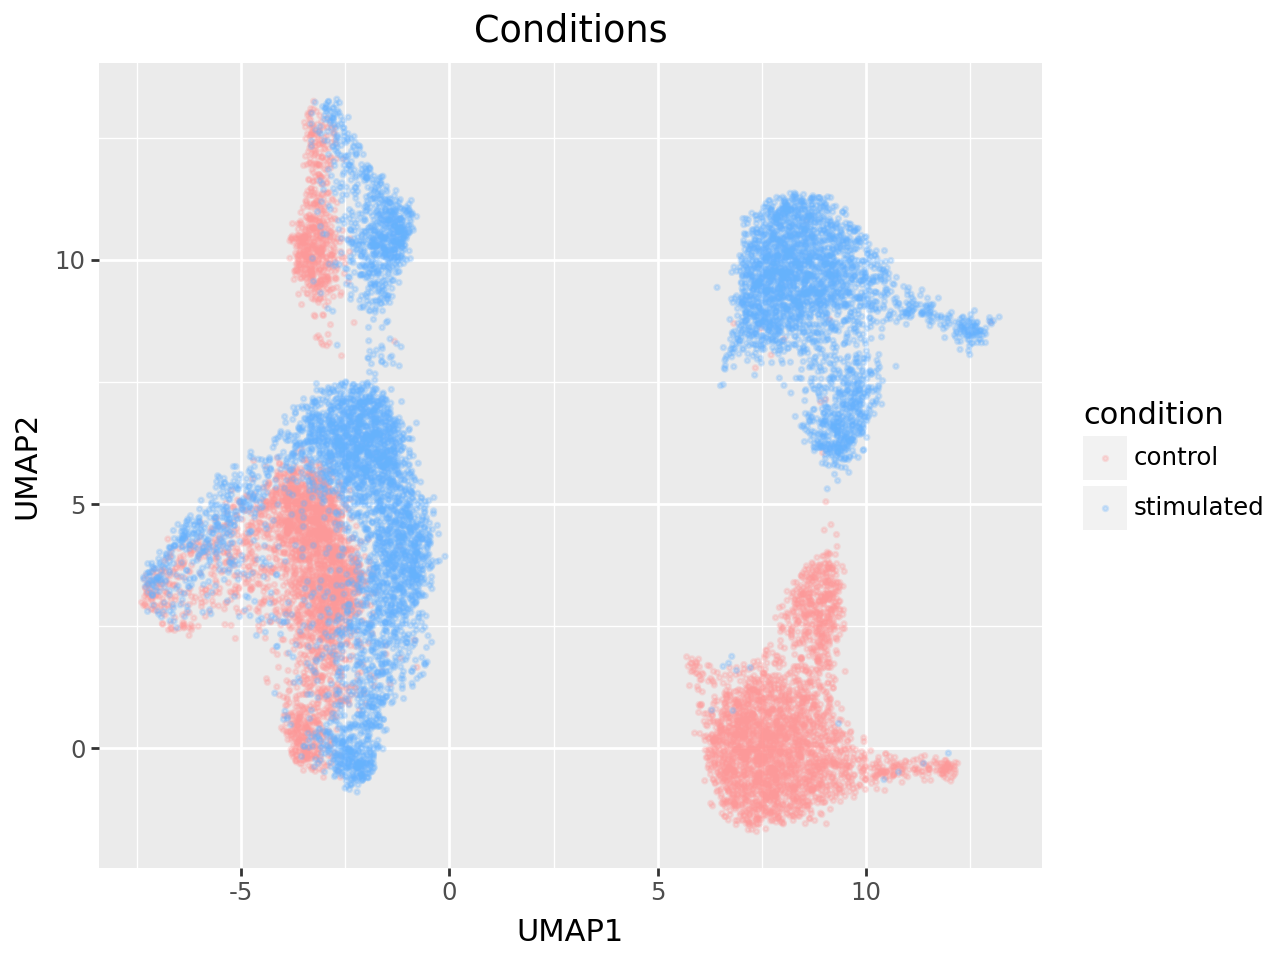

In [41]:
from plotnine import ggplot, aes, geom_point, scale_color_brewer, theme_minimal, labs
(
    ggplot(df_plot, aes(x="x", y="y", color="condition"))
    + geom_point(size=0.5, alpha=0.25)
    + labs(title="Conditions", x="UMAP1", y="UMAP2")
    + scale_color_manual(values=colors_disc)
    # Use colors_disc
)

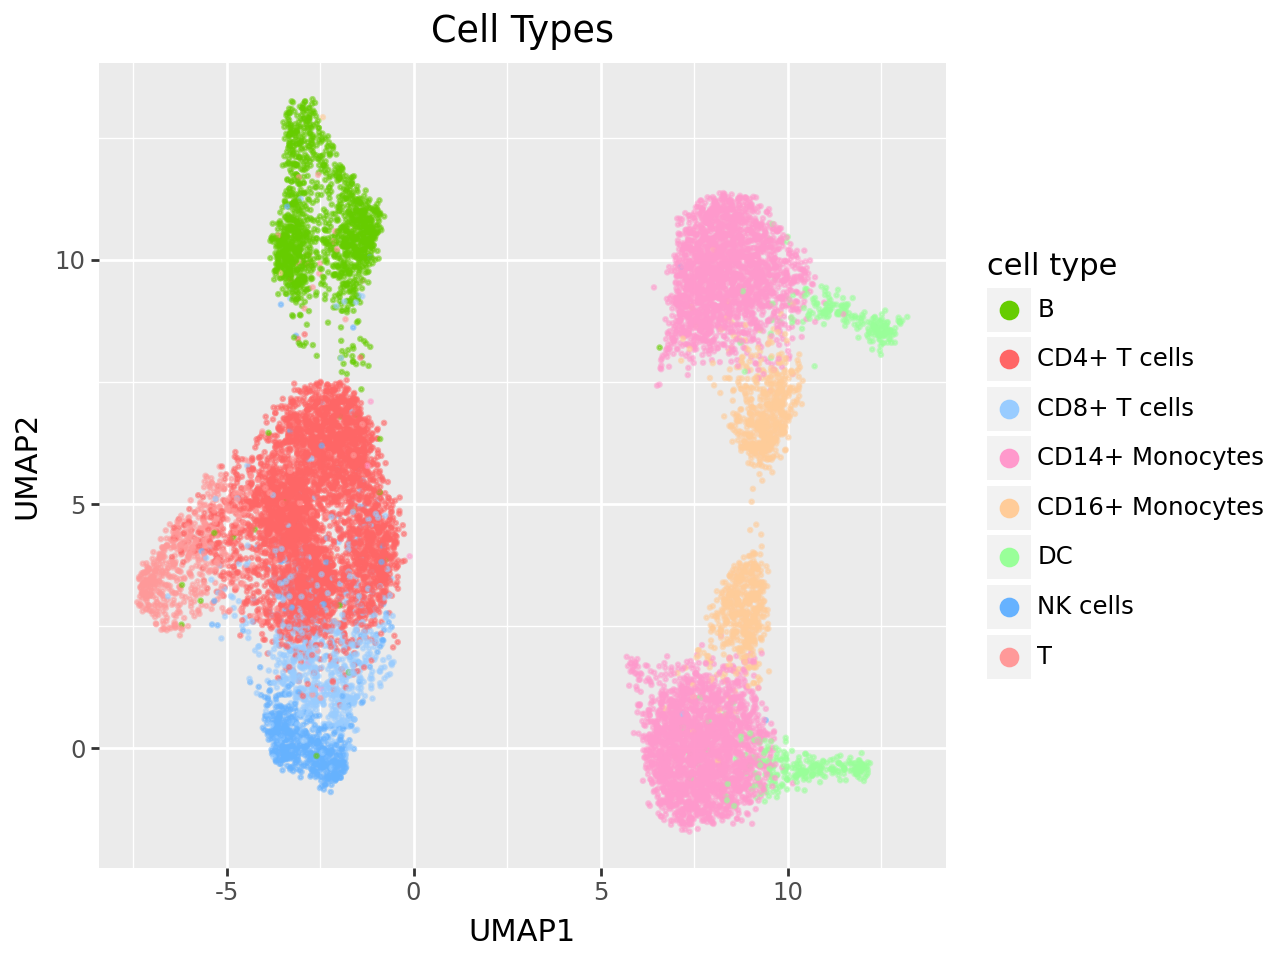

In [42]:
(
    ggplot(df_plot, aes(x="x", y="y", color="cell type"))
    + geom_point(size=0.33, alpha=0.5)
    + labs(title="Cell Types", x="UMAP1", y="UMAP2")
    + scale_color_manual(values=list(reversed(colors_disc)))
    + guides(color=guide_legend(override_aes={'size': 3, 'alpha': 1})))

sc.pl.umap(adata_latent, color=["condition", "cell_type"])

In [43]:
sc.tl.rank_genes_groups(adata_latent, groupby="condition")

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2


In [44]:
del adata_latent.obs["REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"]
del adata_latent.obs["REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"]

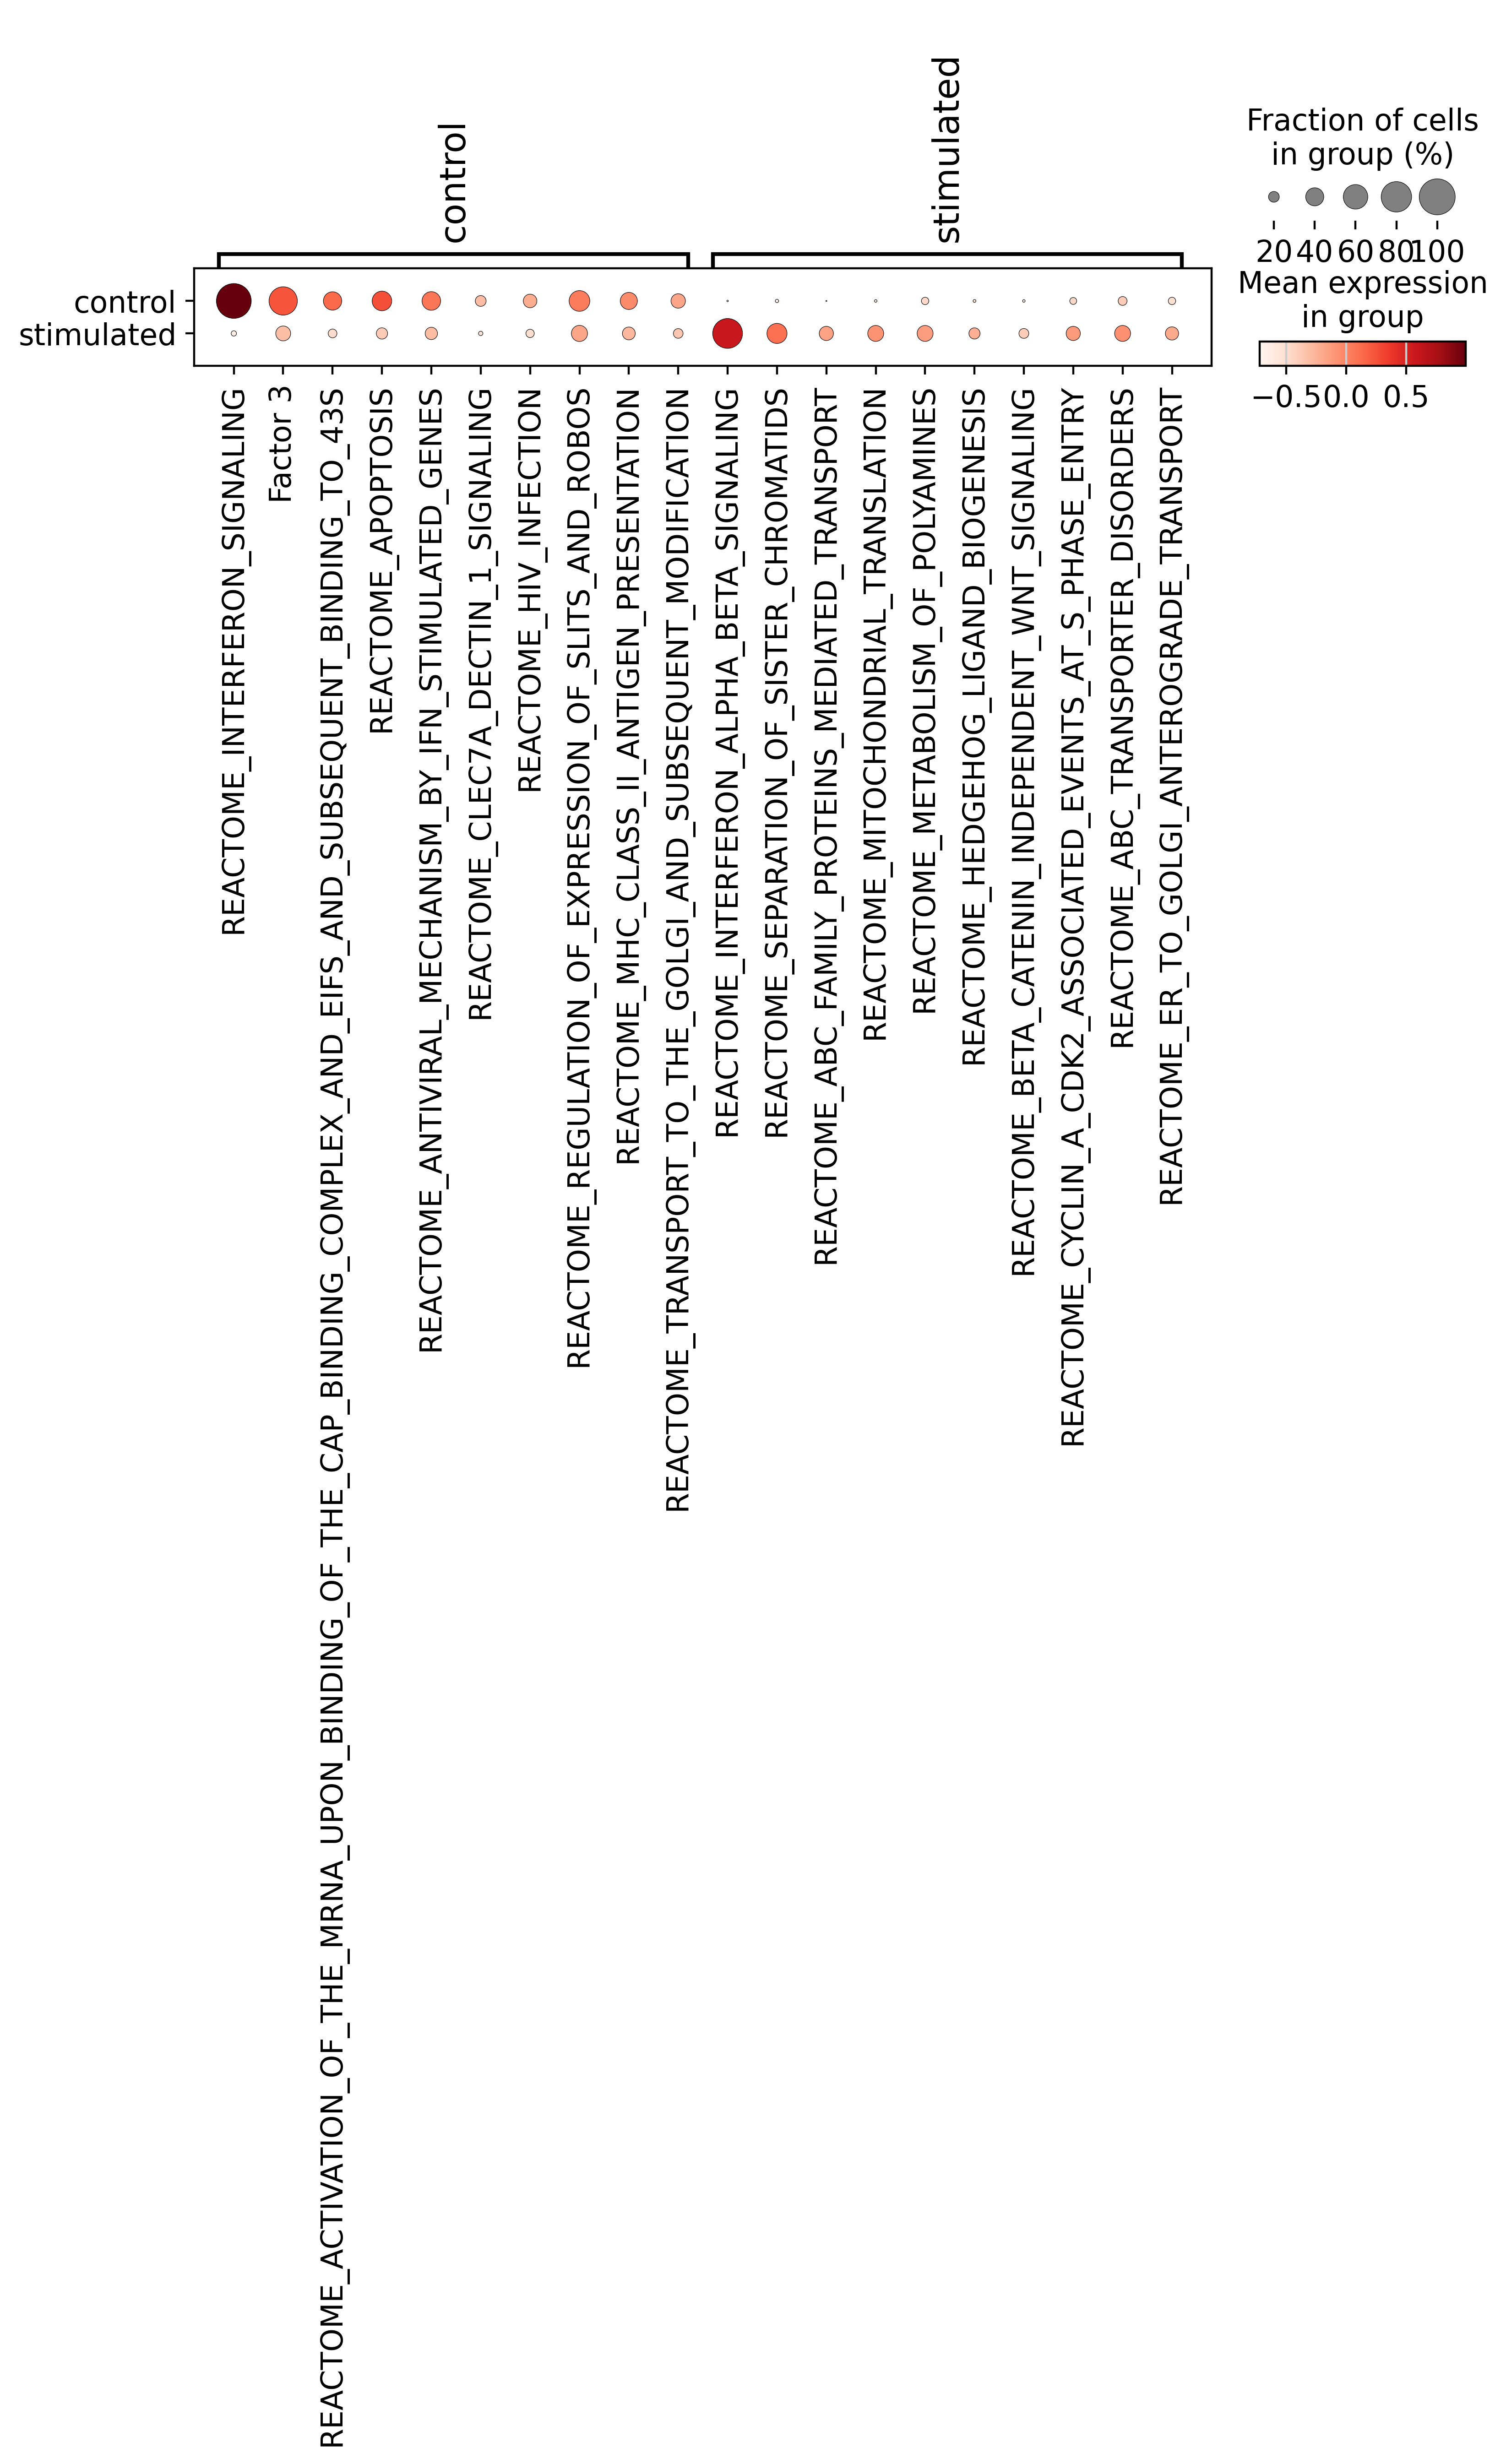

In [45]:
sc.pl.rank_genes_groups_dotplot(adata_latent)

In [46]:
[vn for vn in adata_latent.var_names if "INTERFER" in vn]

['REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA',
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
 'REACTOME_INTERFERON_GAMMA_SIGNALING',
 'REACTOME_INTERFERON_SIGNALING']

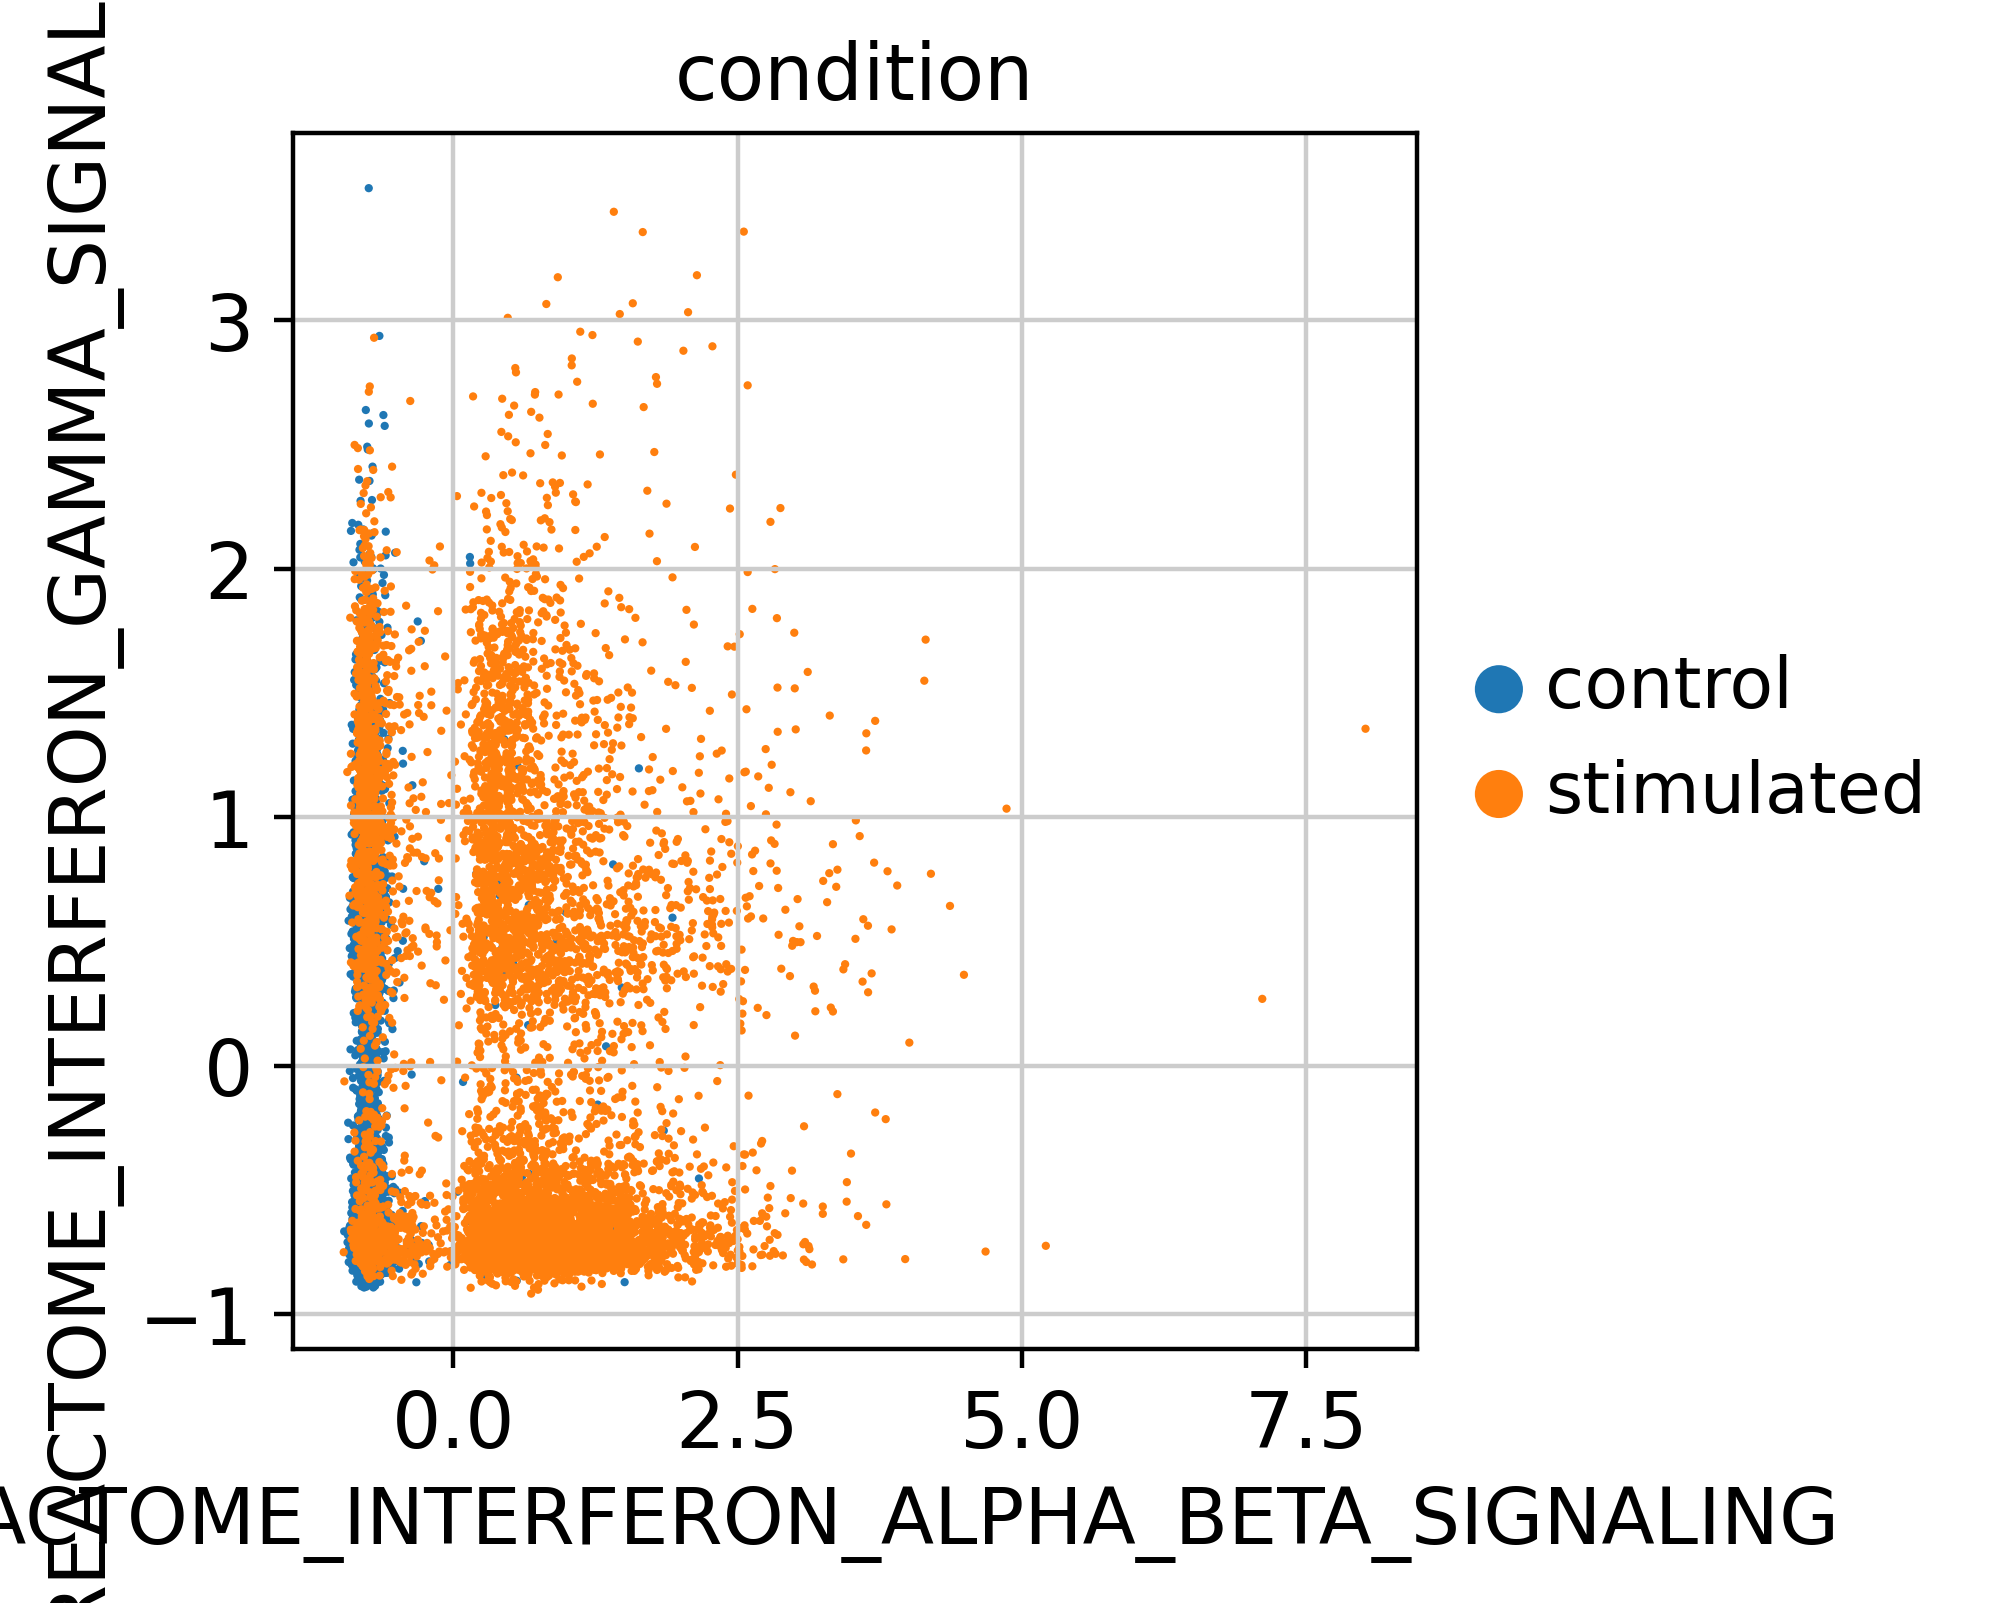

In [47]:
sc.pl.scatter(
    adata_latent,
    x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    y="REACTOME_INTERFERON_GAMMA_SIGNALING",
    color="condition",
)


(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

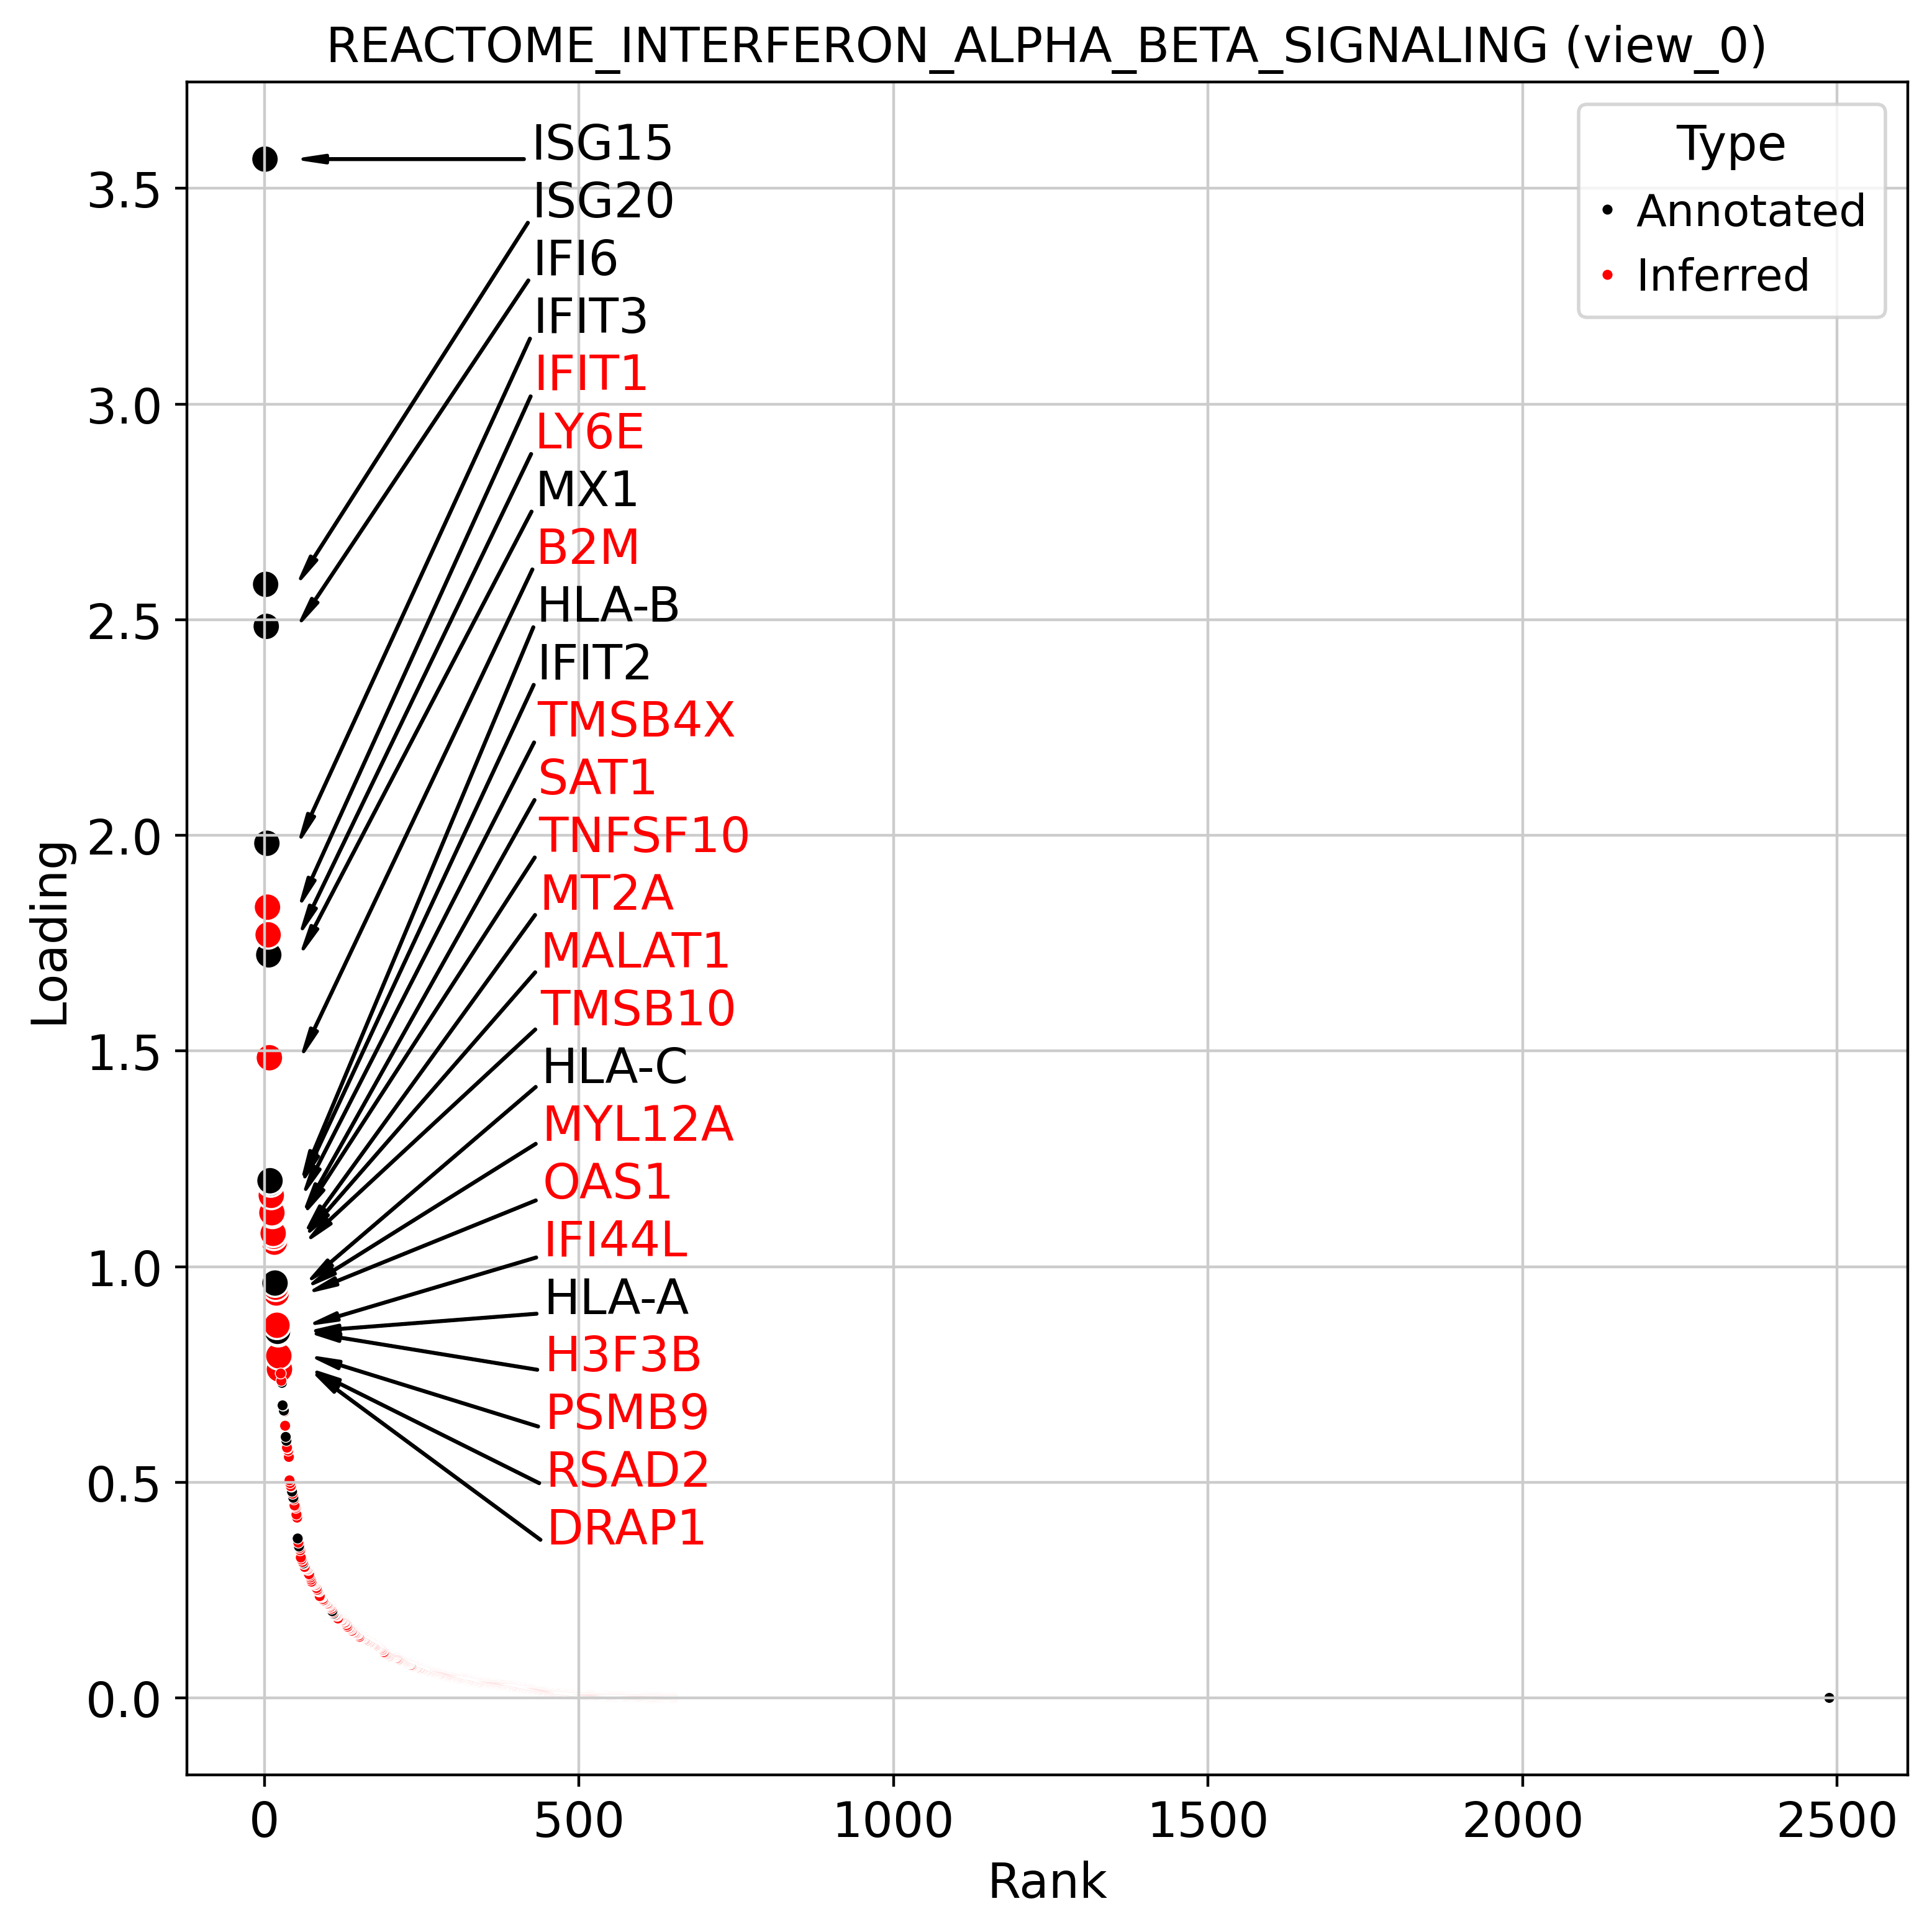

In [48]:
import plotting as pl
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
pl.plot_top_weights(
    model,
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    view_idx="all",
    top=25,
    ranked=True,
)

(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

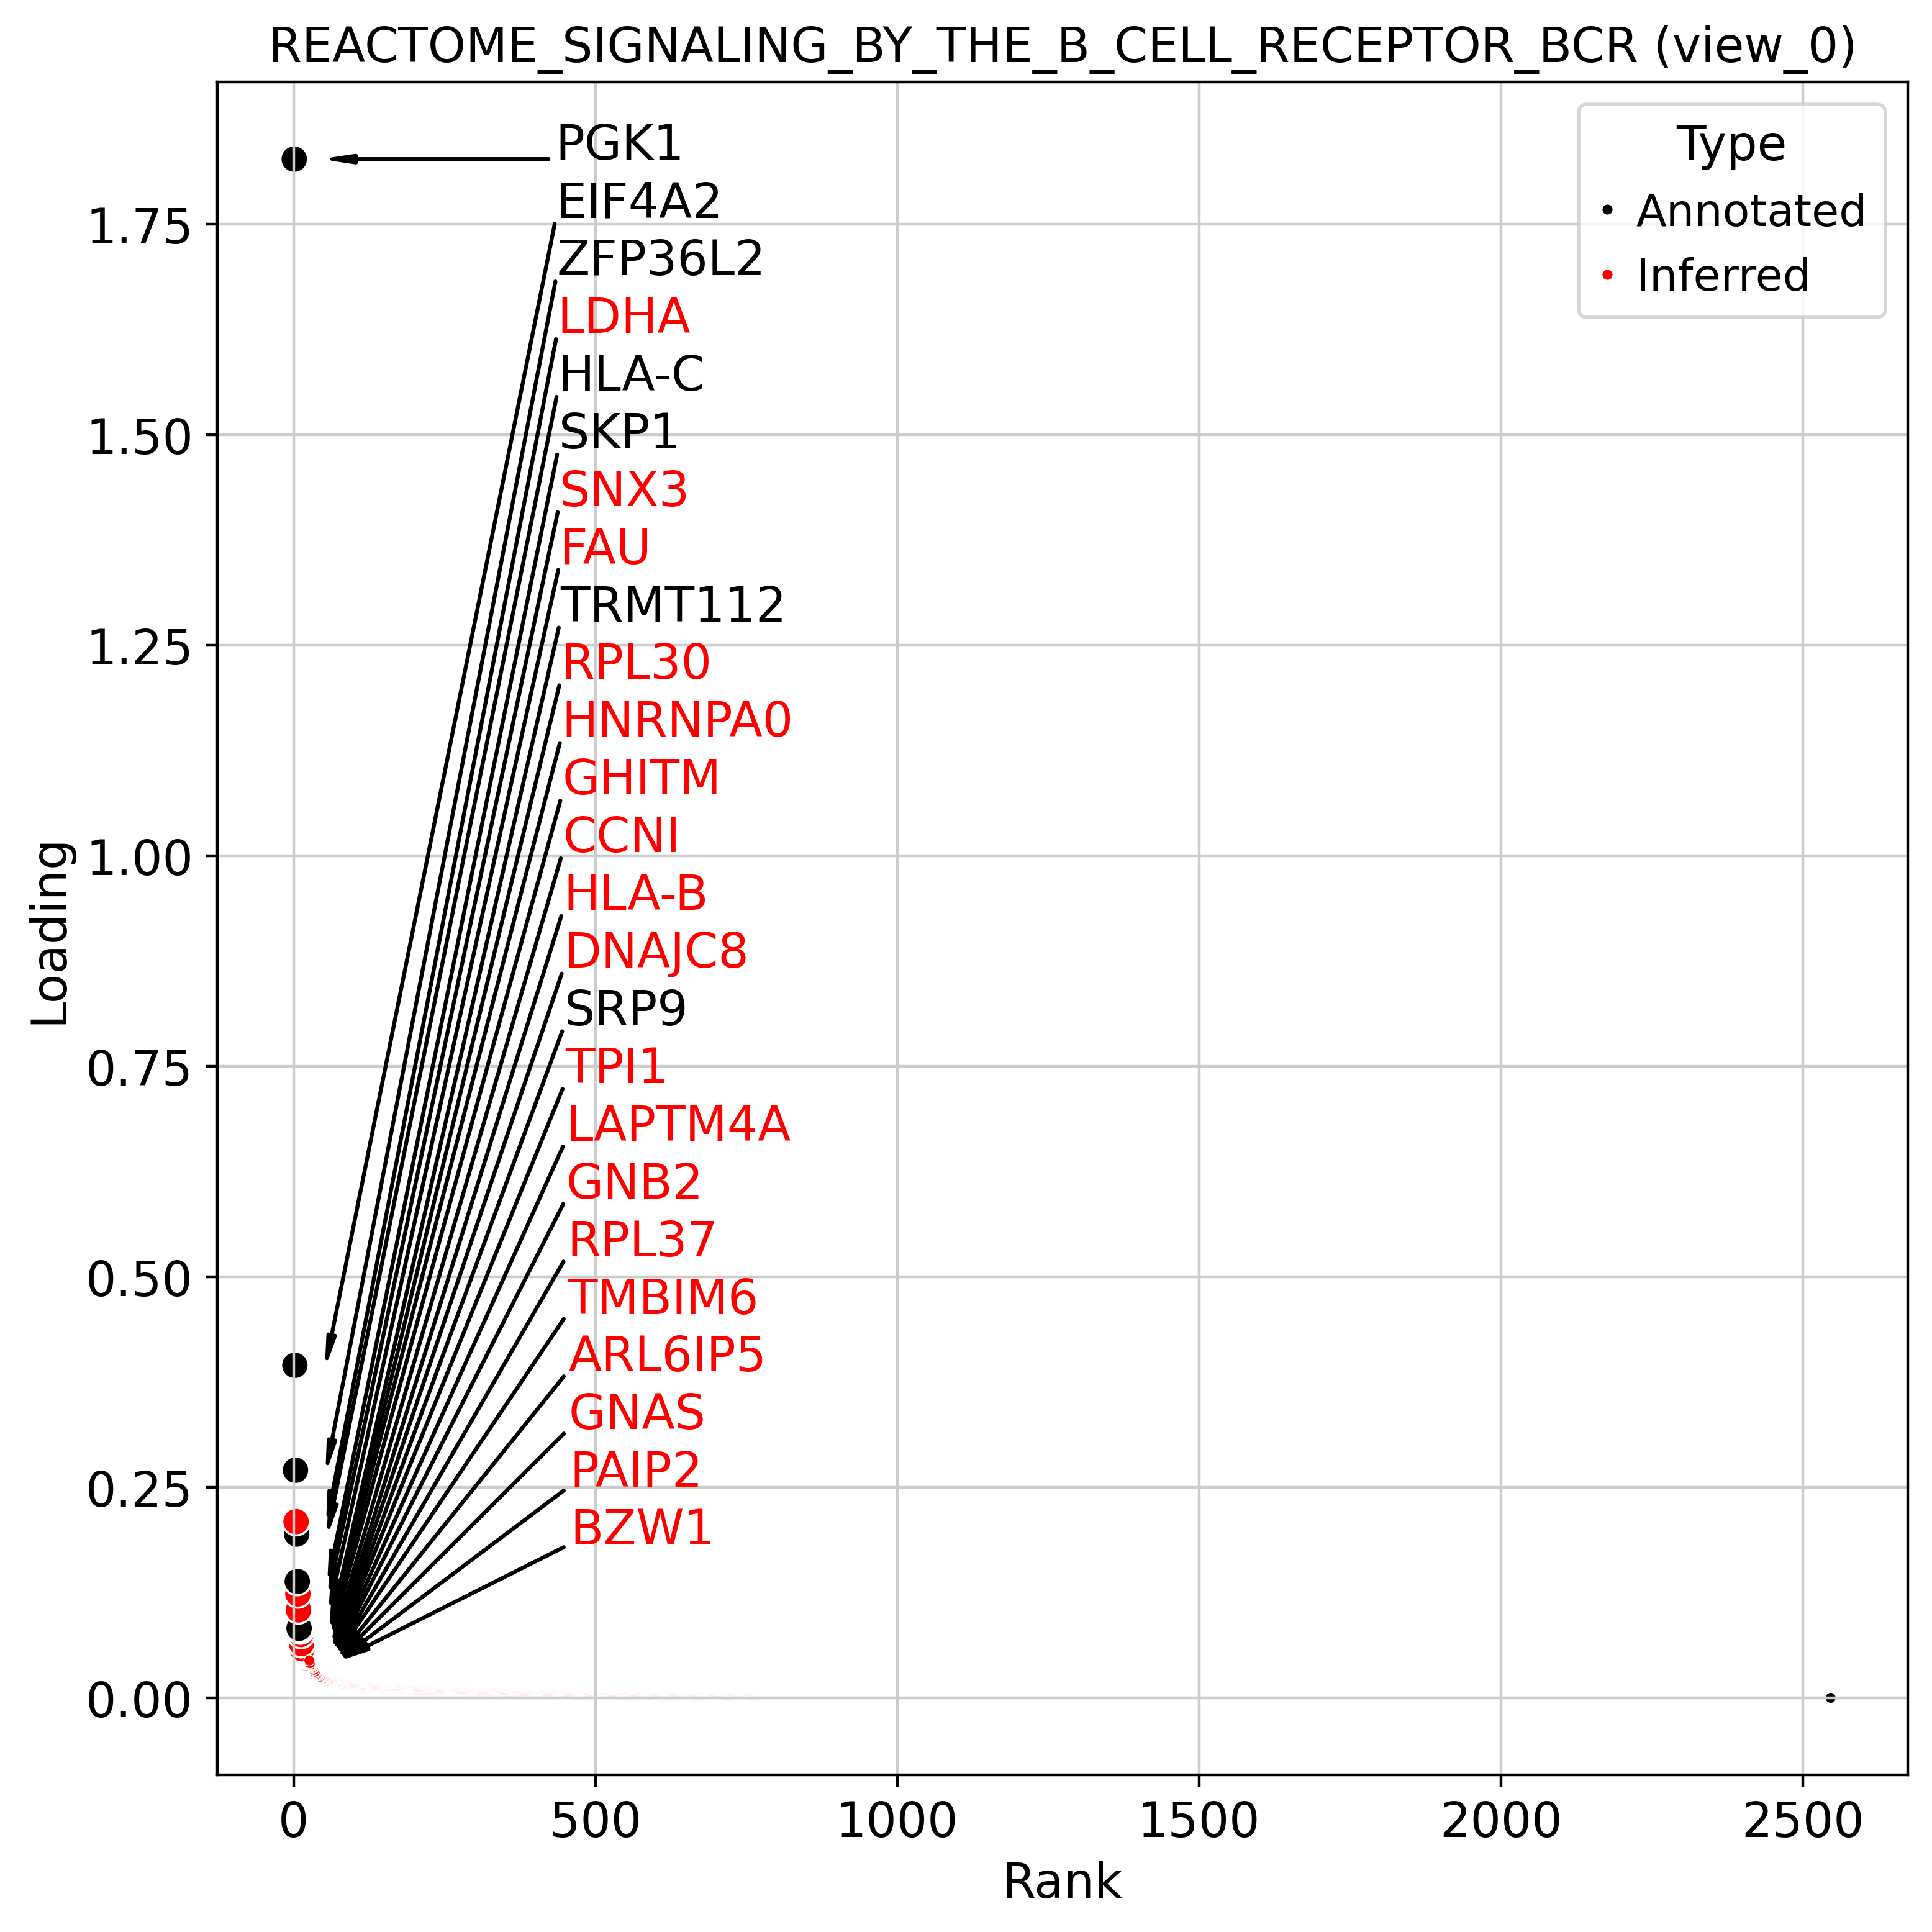

In [49]:
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
pl.plot_top_weights(
    model,
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    view_idx="all",
    top=25,
    ranked=True,
)

In [ ]:
from plotnine import *
import pandas as pd
import numpy as np

def plot_top_weights(model, factor_idx, view_idx="all", top=25, ranked=True, figsize=(5.5,5), **kwargs):
    if isinstance(factor_idx, int):
        factor_idx = model.factor_names[factor_idx - 1]
    if isinstance(factor_idx, str):
        factor_idx = [factor_idx]
    if view_idx == "all":
        view_idx = model.view_names
    if isinstance(view_idx, str):
        view_idx = [view_idx]

    plots = []

    for view_name in view_idx:
        for factor_name in factor_idx:

            factor_loadings = model.get_weights("pandas")[view_name].loc[factor_name, :]
            factor_mask = pd.Series(False, index=factor_loadings.index)
            annotations = model.get_annotations("pandas")[view_name]

            if annotations is not None:
                factor_mask = annotations.loc[factor_name, :]
            factor_loadings_abs = np.abs(factor_loadings)
            factor_loadings_rank = factor_loadings.rank(ascending=False)

            data = pd.DataFrame({
                "Feature": model.feature_names[view_name],
                "Mask": factor_mask,
                "Loading": factor_loadings,
                "Loading (abs)": factor_loadings_abs,
                "Rank": factor_loadings_rank,
                "FP": ~factor_mask & (factor_loadings_abs > 0.0),
            })

            data["Type"] = data["FP"].map({False: "Annotated", True: "Inferred"})

            if top > 0:
                data = data.sort_values("Loading (abs)", ascending=True)
                data = data.iloc[-top:]

            if ranked:
                p = (
                    ggplot(data, aes(x="Rank", y="Loading", color="Type"))
                    + geom_point(size=3)
                    + scale_color_manual(values={"Annotated": "black", "Inferred": "red"})
                    + labs(title=f"{factor_name.replace('_', ' ')}")
                    + theme(figure_size=figsize)
                )

                # Add labels for top features
                labeled_data = data.sort_values("Loading", ascending=False).copy()
                labeled_data["is_positive"] = labeled_data["Loading"] > 0
                n_positive = labeled_data["is_positive"].sum()
                n_negative = top - n_positive
                num = max(n_positive, n_negative)

                y_max = labeled_data["Loading"].max()
                y_min = labeled_data["Loading"].min()
                x_range = labeled_data["Rank"].max()

                labeled_data["x_text_pos"] = labeled_data["Rank"] + 0.1 * x_range
                labeled_data["y_text_pos"] = (
                    np.linspace(y_max, 0.4 * y_max, num=num)[:n_positive].tolist()
                    + np.linspace(y_min, -0.4 * y_min, num=num)[:n_negative][::-1].tolist()
                )

                p += geom_text(
                    data=labeled_data,
                    mapping=aes(x="x_text_pos", y="y_text_pos", label="Feature", color="Type"),
                    size=10,
                    ha="left",
                    va="center",
                )

                p += geom_segment(
                    data=labeled_data,
                    mapping=aes(x="Rank", y="Loading", xend="x_text_pos", yend="y_text_pos"),
                    arrow=arrow(length=0.1, ends="first", type="closed"),
                    color="black",
                )

            else:
                p = (
                    ggplot(data, aes(x="Loading", y="Feature", color="Type"))
                    + geom_point(size=3)
                    + scale_color_manual(values={"Annotated": "black", "Inferred": "red"})
                    + labs(title=f"{factor_name.replace('_', ' ')}")
                    # + theme_minimal()
                )

            plots.append(p)

    return plots

(4325, 6)


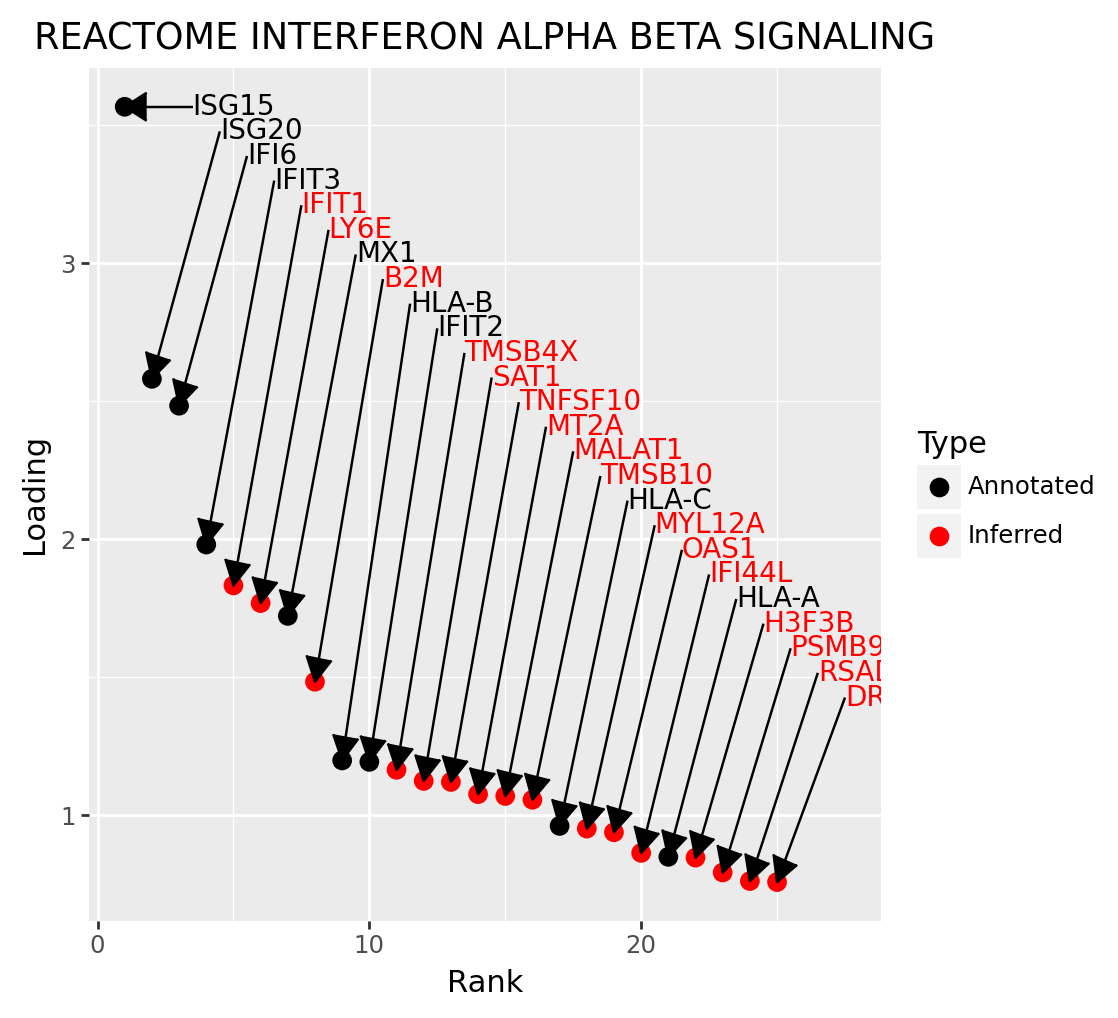

In [56]:
plots = plot_top_weights(
    model,
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    view_idx="all",
    top=25,
    ranked=True,
)
plots[0].draw()